# **Spotify Popularity Prediction**
---

Source: [Kaggle - Spotify Dataset 1921-2020, 160k+ Tracks](https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks)

**Processed by: Guy Kahana & Anat Peled**

> This project is the 3rd assignment required in *Data Science Course, Naya College* and submitted to the instructor Dror Geva.
> The project main purpose was to explore and practice the ML regression processes 


In [2]:
#@title *import statements* { form-width: "20%" }

# General tools
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import Image, HTML
from plotnine import *
import pydot
from plotnine import *

# For transformations and predictions
from scipy.optimize import curve_fit
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import pairwise_distances
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.externals.six import StringIO

# For scoring
from sklearn.metrics import mean_squared_error as mse

# For validation
from sklearn.model_selection import train_test_split as split

sns.set_theme(style="darkgrid")

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


**About The Data**

1. The dataset was uploaded to Kaggle in 06/2020 by *Yamaç Eren Ay*, who used the Spotify Web API for develepors to build a data that contains more than 160,000 songs. These are NOT all the spotify tracks, but quite alot of it...

2. The task in this dataset is to predict the popularity of the track according to the track's features. 

3. Each row in the data represent a unique track, identified by a unique ID feature generated by Spotify.

4. The Features of the tracks are:

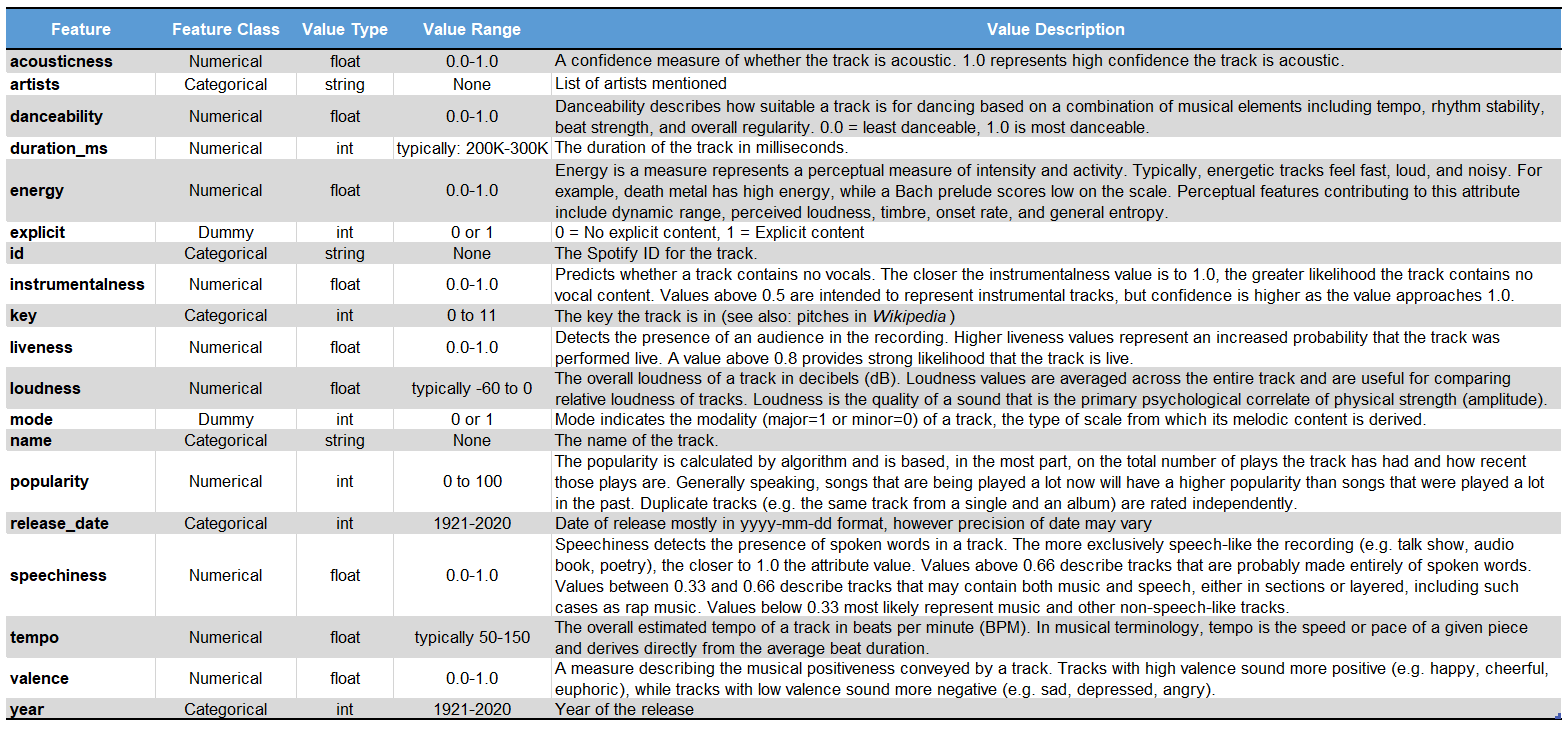

## **Import the data**

In [ ]:
#@title *Option 1: Upload the file locally*

from google.colab import files
uploaded = files.upload()
df = pd.read_csv(r'data.csv')

In [3]:
#@title *Option 2: Mount Personal Google Drive*
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/Guy & Anat/
df = pd.read_csv('data.csv')

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1KpFy8NxkqJfy_mUVWqd3VQtRpqDAdIH6/Guy & Anat


In [ ]:
#@title *Option 3: Direct API to Kaggle dataset using personal acount*

# Needs to prior put the kaggle.json file in the folder
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Guy & Anat/"
#This is the path where kaggle.json is present in the Google Drive

# changing the working directory
%cd /content/gdrive/My Drive/Guy & Anat/
!kaggle datasets download -d yamaerenay/spotify-dataset-19212020-160k-tracks

#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

df = pd.read_csv('data.csv')

# **A first glance...**
---

In [4]:
# Showing 5 first lines of the data
df.head()

acousticness                                   artists  ...  valence  year
0         0.995                       ['Carl Woitschach']  ...   0.7790  1928
1         0.994  ['Robert Schumann', 'Vladimir Horowitz']  ...   0.0767  1928
2         0.604                   ['Seweryn Goszczyński']  ...   0.8800  1928
3         0.995                      ['Francisco Canaro']  ...   0.7200  1928
4         0.990  ['Frédéric Chopin', 'Vladimir Horowitz']  ...   0.0693  1928

[5 rows x 19 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169909 entries, 0 to 169908
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      169909 non-null  float64
 1   artists           169909 non-null  object 
 2   danceability      169909 non-null  float64
 3   duration_ms       169909 non-null  int64  
 4   energy            169909 non-null  float64
 5   explicit          169909 non-null  int64  
 6   id                169909 non-null  object 
 7   instrumentalness  169909 non-null  float64
 8   key               169909 non-null  int64  
 9   liveness          169909 non-null  float64
 10  loudness          169909 non-null  float64
 11  mode              169909 non-null  int64  
 12  name              169909 non-null  object 
 13  popularity        169909 non-null  int64  
 14  release_date      169909 non-null  object 
 15  speechiness       169909 non-null  float64
 16  tempo             16

# **Cleaning**
---

## **Features Selection**

Looking closely at the features, there are some features to consider whether to include in the final model or not:

* **id:** id is unique for each track, therfore cannot assist a model and will be dropped.
* **name:** There are 132,940 unique values. In our opinion, this is a problematic categorical feature to insert in a model, and will be dropped.
* **artists:** there are 33,375 unique features. Since we enticipate the artist will influence the popularity of the track, this feature will remain and be handled seperatley.
* **release_date \ year:** The year feature is a derivative to the release_date feature, therfore one of them should be excluded. Since the release date contains rows with full date and others with year only, the release_date will be dropped.  

In [6]:
columns = ['id', 'name', 'artists', 'release_date', 'year']
for col in columns:
  print(f'{col:<15}: {df[col].nunique()} unique values')

id             : 169909 unique values
name           : 132940 unique values
artists        : 33375 unique values
release_date   : 10882 unique values
year           : 100 unique values


In [7]:
df = df.drop(labels=['id', 'name', 'release_date'], axis=1)
df.shape

(169909, 16)

##**Duplicates & Nulls**

Prior to the feature dropped above, there were not any duplicates in the data set, due to the unique id feature.

After the a.m. features removal, there are 669 duplicates in the dataset.

Only the first copy of the duplicate will remain for the model.

There are not null values in the data set. 

In [8]:
df.duplicated().sum()

669

In [9]:
df = df[~df.duplicated()==1]
df.shape

(169240, 16)

In [10]:
df.isnull().sum().sum()

0

#**EDA**
---

## **Overview**

In [11]:
numeric_columns = df.columns[df.dtypes != 'object']
string_columns = df.columns[df.dtypes == 'object']
print(f'There are {len(numeric_columns)} numeric columns & {len(string_columns)} string columns')

There are 15 numeric columns & 1 string columns


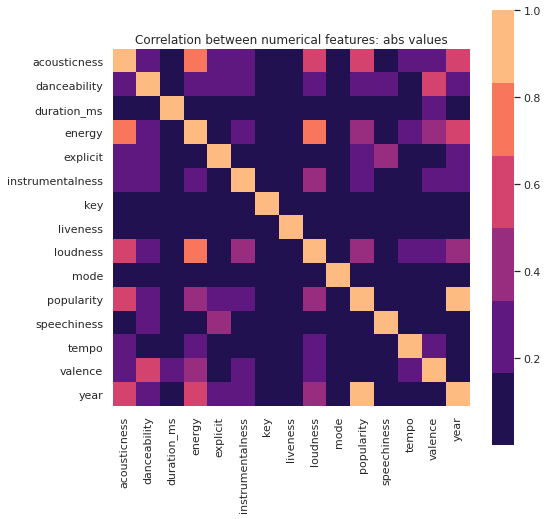

In [12]:
# Numeric Heatmap
numeric_df = pd.DataFrame(data=df, columns=numeric_columns, index=df.index)
corr = np.abs(numeric_df.corr())
fig, ax = plt.subplots(figsize=(8, 8))
cmap = sns.color_palette("magma")
sns.heatmap(corr, cmap=cmap, square=True)
plt.title('Correlation between numerical features: abs values')
plt.show()

In [13]:
series = np.abs(corr['popularity']).sort_values(ascending=False)
print('The most linear correlated features to POPULARITY are:')
for i, row in enumerate(series):
    if 0.2 <= row < 1:
      print(f'{series.index[i]:17} --> {row: .2f} (abs)')

The most linear correlated features to POPULARITY are:
year              -->  0.88 (abs)
acousticness      -->  0.59 (abs)
energy            -->  0.49 (abs)
loudness          -->  0.46 (abs)
instrumentalness  -->  0.30 (abs)
danceability      -->  0.22 (abs)
explicit          -->  0.21 (abs)


In [14]:
#@title
# sns_plot = sns.pairplot(df.sample(1000), height=1, vars=['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
#        'instrumentalness', 'key', 'liveness', 'loudness', 
#        'speechiness', 'tempo', 'valence', 'year'])
# sns_plot.savefig('pairplot.png')
# plt.title('Pairplot of Numerical Features exc. dummies')
# plt.show()

**Pairplot of Numerical data excluding dummies**

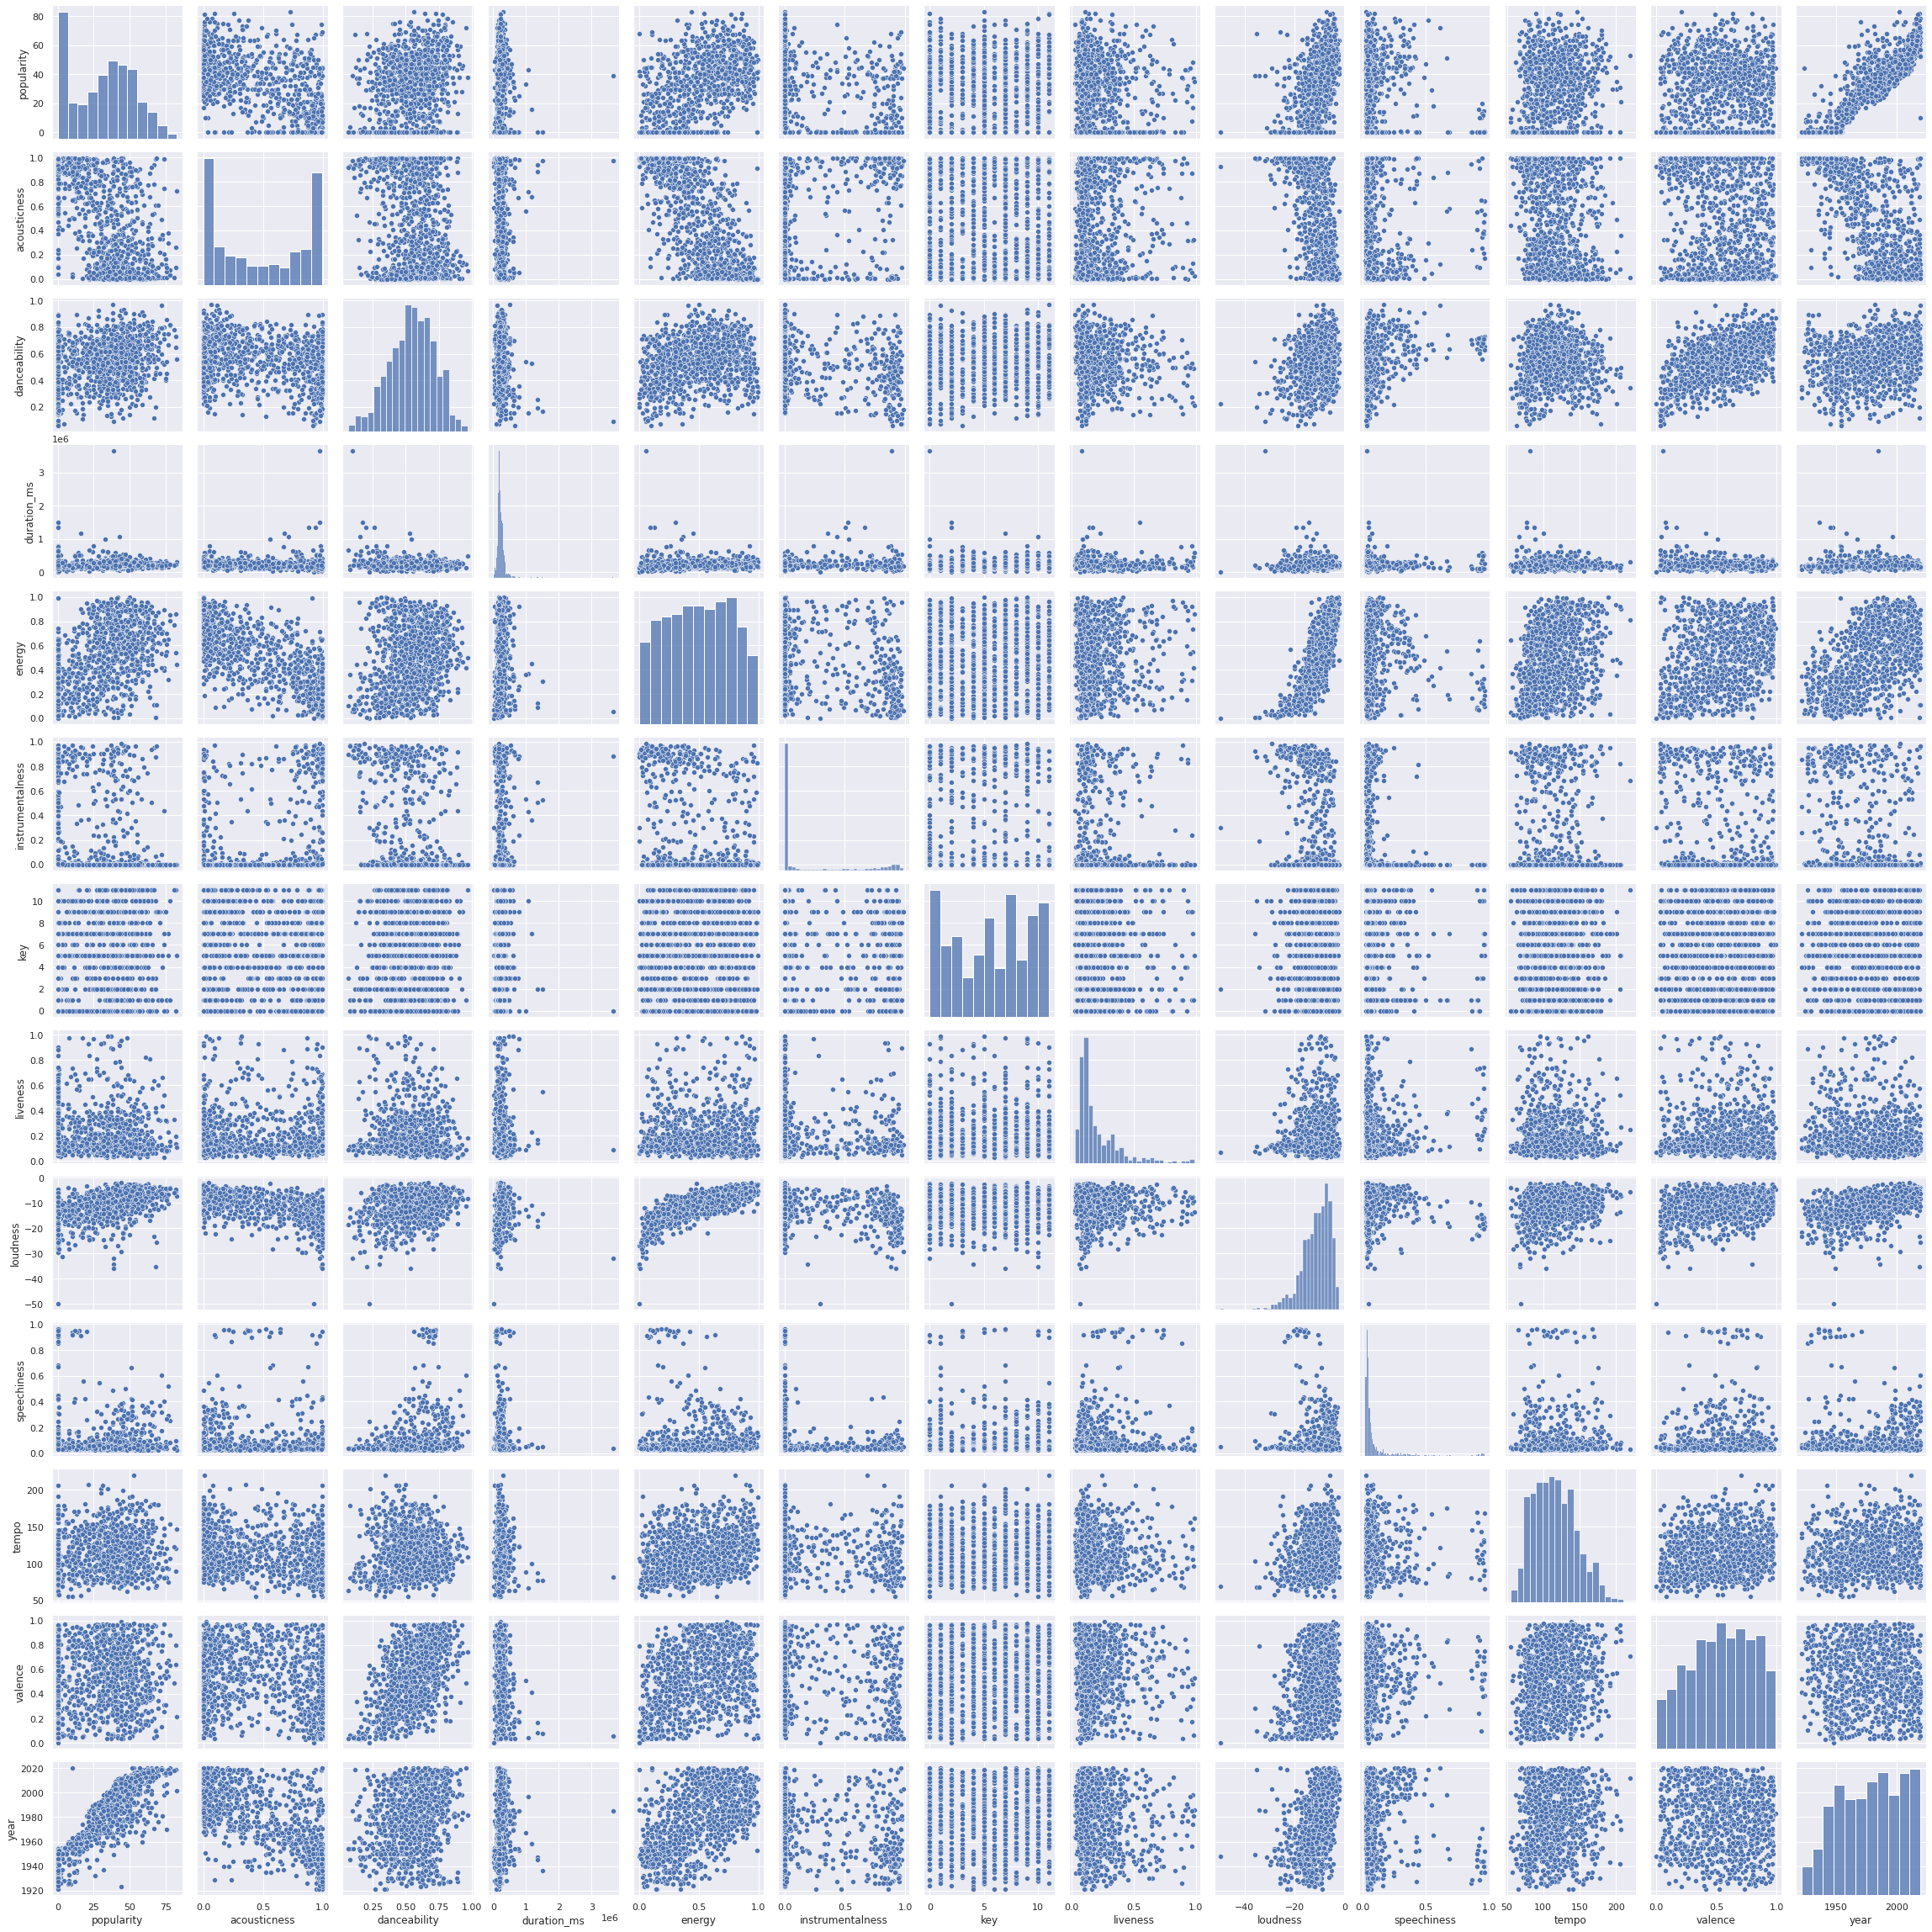

In [ ]:
Image(filename='pairplot_1.png')

## **Categorical Features**
---

### **Artists**

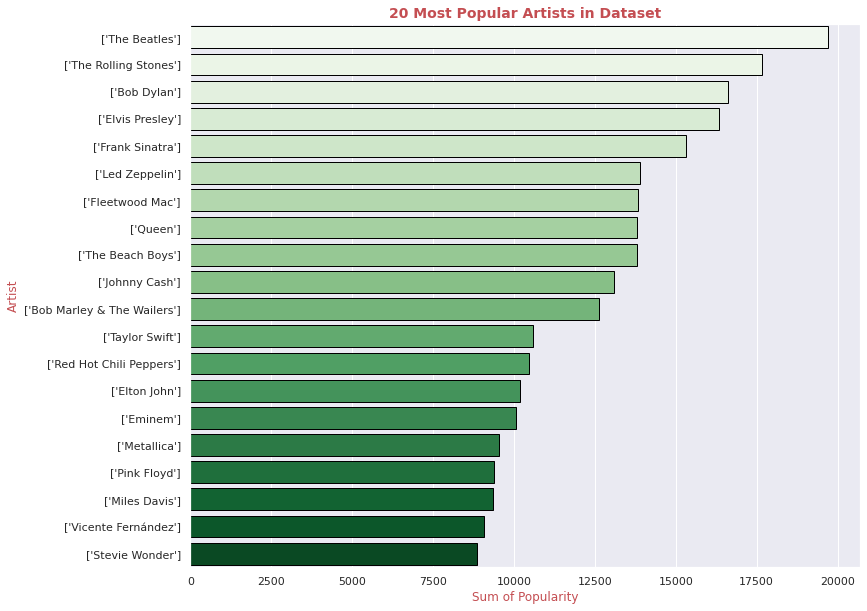

In [15]:
#@title  { form-width: "20px" }
# # Plotting
fig, ax = plt.subplots(figsize = (12, 10))
lead_artists = df.groupby('artists')['popularity'].sum().sort_values(ascending=False).head(20)
ax = sns.barplot(x=lead_artists.values, y=lead_artists.index, palette="Greens", orient="h", edgecolor='black', ax=ax)
ax.set_xlabel('Sum of Popularity', c='r', fontsize=12)
ax.set_ylabel('Artist', c='r', fontsize=12)
ax.set_title('20 Most Popular Artists in Dataset', c='r', fontsize=14, weight = 'bold')
plt.show()

In [ ]:
df['artists'].nunique()

33375

There are 33,375 different artists in this feature.

Since we believe there should be a correlation between the artist and the popularity of the track, we would like to use the **Target Encoding** approach, and replace the artist with some derivative of its popularity.

First, we check distribution of number of times artists appear in the data. 

It is clear that most artists apear less than 50 times.

In [16]:
#@title  { form-width: "20px" }
# Adding Mean & Count values to each artist
df['mean'] = df.groupby('artists')['popularity'].transform('mean')
df['count'] = df.groupby('artists')['popularity'].transform('count')

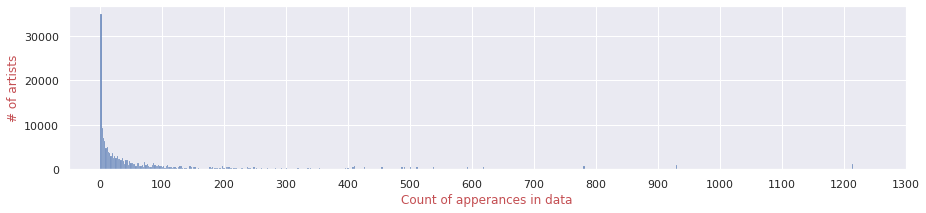

In [ ]:
#@title
fig, ax = plt.subplots(figsize = (15, 3))
ax=sns.histplot(x='count', data=df, bins=600)
ax.set_xlabel('Count of apperances in data', fontsize=12, c='r')
ax.set_ylabel('# of artists', fontsize=12, c='r')
ax.set_xlim(-50,1300)
ax.set_xticks(range(0,1301,100))
plt.show()

Lets zoom in to the left of the scale, to decide what is the cut-off for using artist mean OR overall data mean

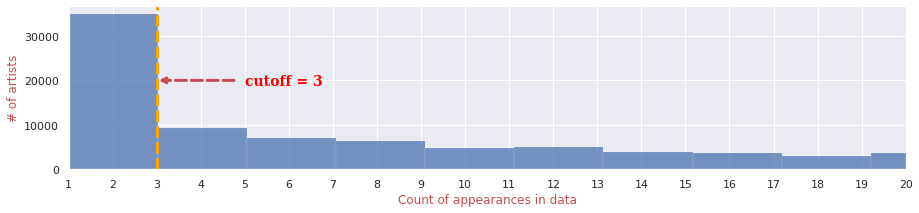

In [ ]:
#@title  { form-width: "20px" }
fig, ax = plt.subplots(figsize = (15, 3))
ax=sns.histplot(x='count', data=df, bins=600)
ax.set_xlabel('Count of appearances in data', fontsize=12, c='r')
ax.set_ylabel('# of artists', fontsize=12, c='r')
ax.set_xlim(1,20)
ax.set_xticks(range(1,21,1))
ax.axvline(x=3, ymin=0, ymax=1, color='orange', linestyle='dashed', linewidth=3)
font = {'family': 'serif',
        'color':  'red',
        'weight': 'bold',
        'size': 14,
        }
ax.annotate("", xy=(3, 20000), xytext=(4.8, 20000), arrowprops=dict(arrowstyle="->", color='r', linestyle='dashed', linewidth=3))
ax.text(x = 5, y = 19000, s='cutoff = 3', fontdict=font)

plt.show()

We also check for correlation between the number of appearances in data and the mean of popularity.

It is clear that artists that appear in the data more than 600 times, are getting almost 0 popularity.

there are 4 artists [Francisco Canaro, Ignacio Corsini, Эрнест Хемингуэй, Эрих Мария Ремарк] responsible for 3,546 tracks!

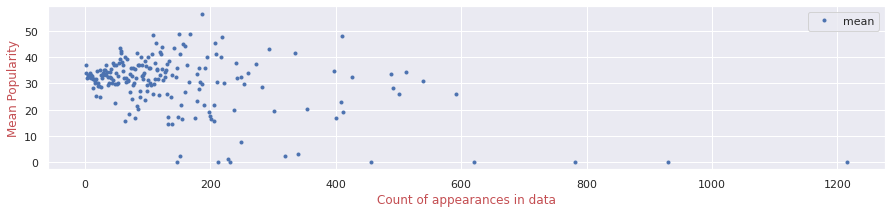

In [ ]:
#@title
fig, ax = plt.subplots(figsize = (15, 3))
stat = df.groupby('count')['mean'].mean().to_frame().reset_index()
ax = stat.plot(x='count', y='mean', marker='.', linestyle = '', ax=ax)
ax.set_xlabel('Count of appearances in data', fontsize=12, c='r')
ax.set_ylabel('Mean Popularity', fontsize=12, c='r')
plt.show()

In [ ]:
#@title
frequent_flyer = df[['artists','mean']].loc[df['count']>600].value_counts(ascending=False).reset_index()
frequent_flyer.columns=['Artist','Mean Popularity', '# of Tracks']
frequent_flyer

Artist  Mean Popularity  # of Tracks
0   ['Эрнест Хемингуэй']         0.000000         1215
1   ['Francisco Canaro']         0.041935          930
2  ['Эрих Мария Ремарк']         0.000000          781
3    ['Ignacio Corsini']         0.024194          620

Therefore to handle this feature we will use a transformer that transforms the 'artists' feature from object
       to a float value as follows:
       
1. Replace the data with the artists mean popularity

2. Replace values where artists appear less thana minimal times with popularity mean

3. Replace values where artists appear more than maximaum times with 0

### **Explicit**

Explicit content usually gets The Parental Advisory label (abbreviated PAL) which is a warning label. It is placed on audio recordings in recognition of profanity or inappropriate references, with the intention of alerting parents of material potentially unsuitable for children. 

The label has been included on digital listings offered by online music stores (as Spotify).

* Linear correlation to popularity is 0.2134

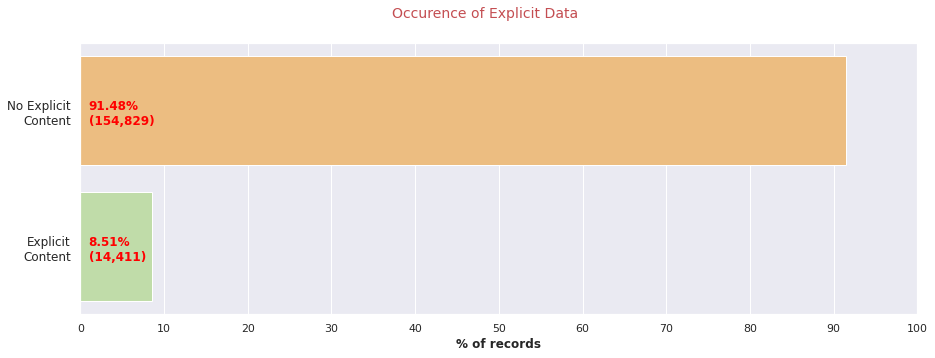

In [ ]:
#@title  { form-width: "20px" }
fig, ax = plt.subplots(figsize = (15, 5))
y_ticks = ['No Explicit\nContent', 'Explicit\nContent']
ax = sns.barplot(x = (df['explicit'].value_counts(normalize=True)*100),
                 y= y_ticks, 
                 data=df, palette='Spectral')
ax.set_xlabel('% of records', fontsize=12, weight='bold')
ax.set_xlim(0.0,100.0)
ax.set_xticks(ticks=range(0,101,10))
ax.set_yticklabels(labels=y_ticks, fontsize=12)
ax.text(s='91.48%\n(154,829)', x=1, y=0.1, fontdict={'weight': 'bold', 'c':'red'})
ax.text(s='8.51%\n(14,411)', x=1, y=1.1, fontdict={'weight': 'bold', 'c':'red'})

plt.suptitle('Occurence of Explicit Data', fontsize=14, c='r')
plt.show()

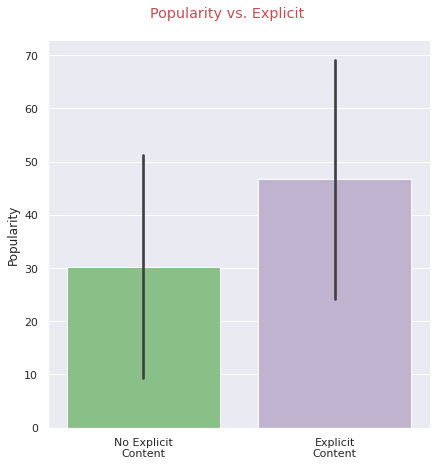

In [ ]:
#@title  { form-width: "20px" }
exp_data = sns.catplot(data=df, kind="bar",
                        x="explicit", y="popularity",
                        ci="sd", palette='Accent',
                        height=6)
exp_data.fig.suptitle('Popularity vs. Explicit', y=1.05, c='r')
exp_data.set_axis_labels("", "Popularity")
exp_data.set_xticklabels(['No Explicit\nContent', 'Explicit\nContent'])
plt.show()

### **Key**

* The 11-values of keys distribute between 4-13% each 

* Keys popularity' std is aprox. 20, makes it difficult to establish any correlation.

* Key 3 has the lowest mean (of 24.67) 

In [ ]:
df['duration_ms'].corr(df['popularity'])

0.0629120751235153

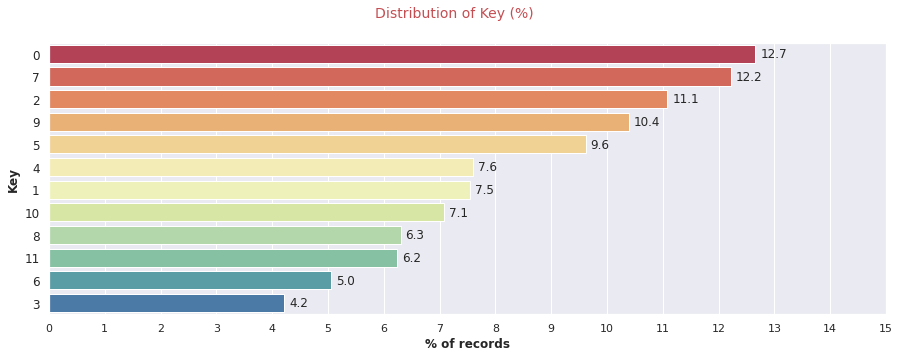

In [ ]:
#@title  { form-width: "20px" }
fig, ax = plt.subplots(figsize = (15, 5))
key_data = df['key'].value_counts(normalize=True, sort=True, ascending=True)*100
y_ticks = df['key'].value_counts().index
ax = sns.barplot(x = key_data.values, y= y_ticks, data = key_data, orient='h', palette='Spectral')
ax.set_xlabel('% of records', fontsize=12, weight='bold')
ax.set_ylabel('Key', fontsize=12, weight='bold')
ax.set_xlim(0.0,15.0, 0)
ax.set_xticks(ticks=range(0,16,1))
ax.set_yticklabels(labels=y_ticks, fontsize=12) #

rects = ax.patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width() #f'{rect.get_width():.2f}'
    y_value = rect.get_y() + rect.get_height() / 2
    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    ha = 'left'

    # Use X value as label and format number with one decimal place
    label = f'{x_value:.1f}'

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.

plt.suptitle('Distribution of Key (%)', fontsize=14, c='r')
plt.show()

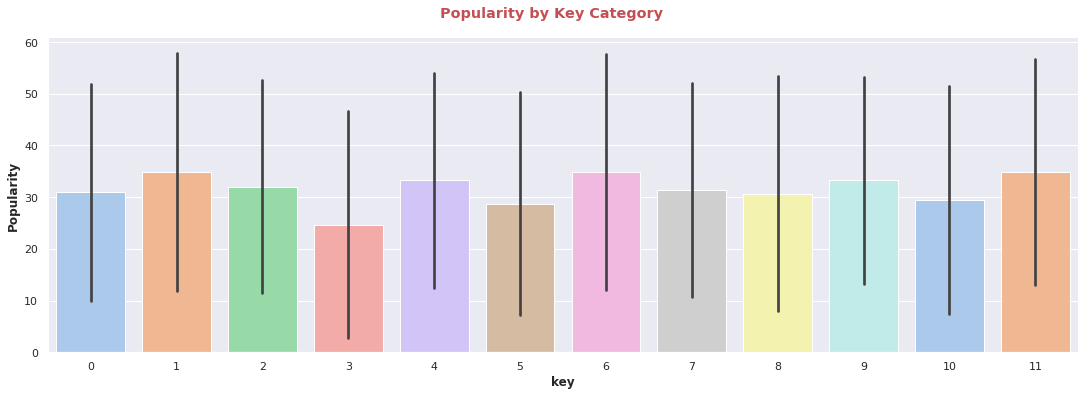

In [ ]:
#@title  { form-width: "20px" }
exp_data = sns.catplot(data=df, kind="bar",
                        x="key", y="popularity",
                        palette='pastel',
                        ci = 'sd',
                        height=5, aspect = 3)
exp_data.fig.suptitle('Popularity by Key Category', y=1.05, c='r', weight='bold')
exp_data.set_axis_labels("key", "Popularity", fontsize=12, weight='bold')
plt.show()

### **Mode**

* Mode is a binary feature.

* There is no distinguish linear connection between mode and popularity (corr = -0.033)

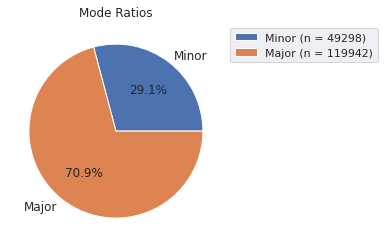

In [ ]:
#@title  { form-width: "20px" }
ax = df.groupby('mode')['popularity'].count().plot.pie(labels=['Minor', 'Major'],
                                 autopct='%1.1f%%', 
                                 fontsize=12)
ax.set_ylabel('')
ax.set_title('Mode Ratios')
ax.legend(labels=['Minor (n = 49298)', 'Major (n = 119942)'], bbox_to_anchor=(1, 1))
a = ax.get_anchor
plt.show()

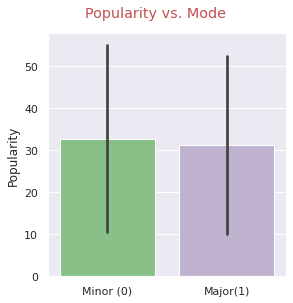

In [ ]:
#@title
exp_data = sns.catplot(data=df, kind="bar",
                        x="mode", y="popularity",
                        ci="sd", palette='Accent',
                        height=4)
exp_data.fig.suptitle('Popularity vs. Mode', y=1.05, c='r')
exp_data.set_axis_labels("", "Popularity")
exp_data.set_xticklabels(['Minor (0)', 'Major(1)'])
plt.show()

## **Numeric Features**
---

### **Acousticness**

> The acousticness of the majority of tracks is either close to 0 or 1

> The more confidence we have that a track is acoustic, the less is its mean popularity (apply for acousitcness > 0.1)

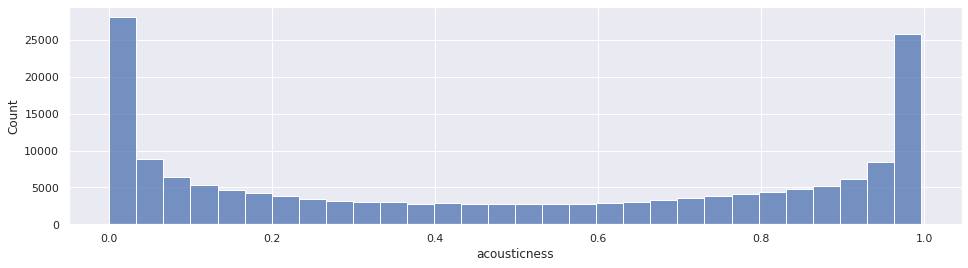

In [ ]:
#@title
fig, ax = plt.subplots(figsize=(16, 4))
sns.histplot(x='acousticness', data=df, bins=30)
plt.show()

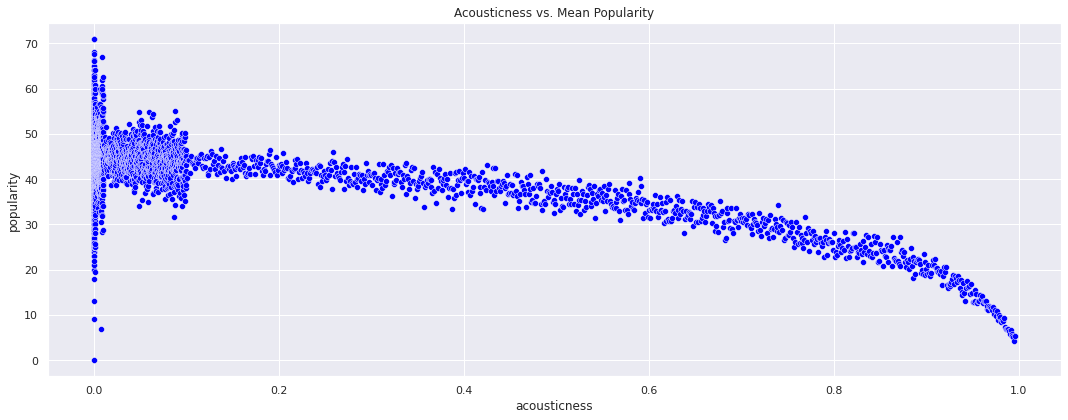

In [ ]:
#@title
fig, ax = plt.subplots(figsize=(15, 6))
ax1_data =  df.groupby('acousticness')['popularity'].mean().to_frame()
ax = sns.scatterplot(x='acousticness', y='popularity', data=ax1_data, color='blue', ax=ax)
ax.set_title('Acousticness vs. Mean Popularity')
ax1.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

### **Danceability**

>Danceability- measure if the song is dancable based on the combination of tempo rythm and beat strength

>Danceability seems to have a normal distribution between 0-1

>the majoirity of Danceability values is between 0.2-0.8 with mean 0.53



In [ ]:
#@title
a= df['danceability'].corr(df['popularity']).round(2)
print(f'The pearדon corr is -->{a:^10}')

The pearדon corr is -->   0.22   


In [ ]:
#@title
df['danceability'].describe()

count    169240.000000
mean          0.538717
std           0.175194
min           0.000000
25%           0.418000
50%           0.549000
75%           0.668000
max           0.988000
Name: danceability, dtype: float64

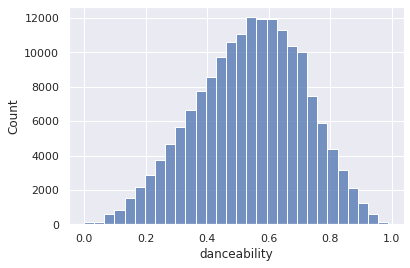

In [ ]:
#@title
sns.histplot(x='danceability', data=df, bins=30)
plt.show()

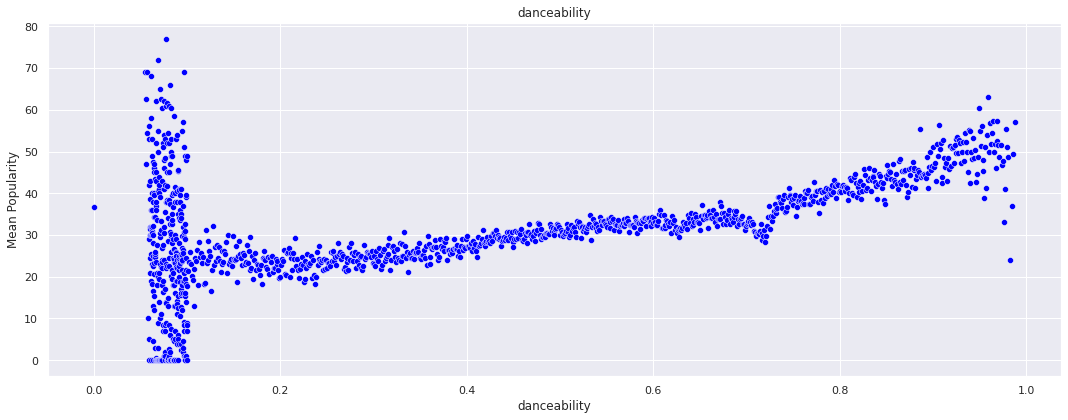

In [ ]:
#@title
fig, ax = plt.subplots(1, figsize=(15, 6), sharey=True, sharex = True)
ax_data =  df.groupby('danceability')['popularity'].mean().to_frame()
ax = sns.scatterplot(x='danceability', y='popularity', data=ax_data, color='blue', ax=ax)
ax.set_title('danceability')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

### **Duration_ms**

* Conveting the miliseconds to minutes, so the column is more intuitive

* mean (3.85 min) and median (3.47 min) are close

* Some tracks are unexpectedly long... to understand the data it was divided to long tracks and short tracks:

    * Long tracks are mainly classic music and atmosphere music

    * plottibg it vs. mean popularity, it seems as a natural extension

    * There are not enoughe samples of tracks longer than 45 minutes

In [ ]:
#@title
# convert the miliseconds to minutes
df['duration_min'] = df['duration_ms']/60000
df['duration_min'].describe()

count    169240.000000
mean          3.857319
std           2.018018
min           0.085133
25%           2.852946
50%           3.477333
75%           4.382450
max          90.058333
Name: duration_min, dtype: float64

In [ ]:
long_tracks = df.loc[df['duration_min']>20]
short_tracks = df.loc[df['duration_min']<=20]

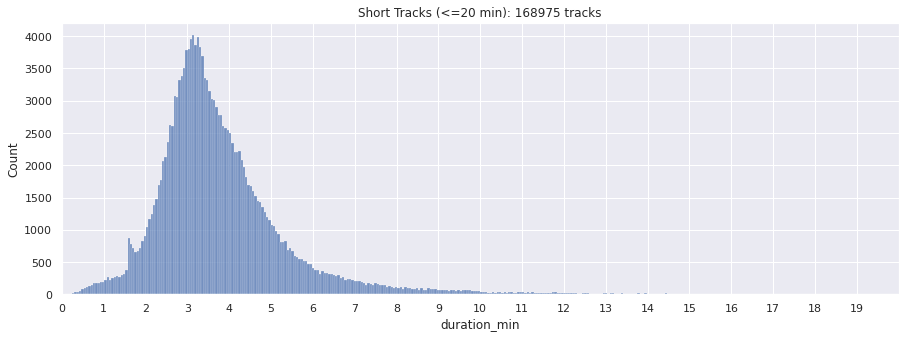

In [ ]:
#@title
fig, ax = plt.subplots(figsize = (15, 5))
ax = sns.histplot(data=short_tracks, x='duration_min')
ax.set_title(f'Short Tracks (<=20 min): {short_tracks.shape[0]} tracks')
ax.set_xticks(range(0,20,1))
ax.set_xlim(0,20)
plt.show()

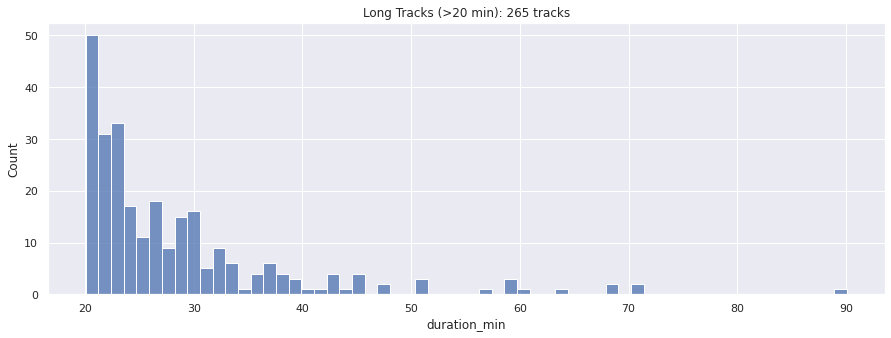

In [ ]:
#@title
fig, ax = plt.subplots(figsize = (15, 5))
ax = sns.histplot(data=long_tracks, x='duration_min', bins=60)
ax.set_title(f'Long Tracks (>20 min): {long_tracks.shape[0]} tracks')
plt.show()

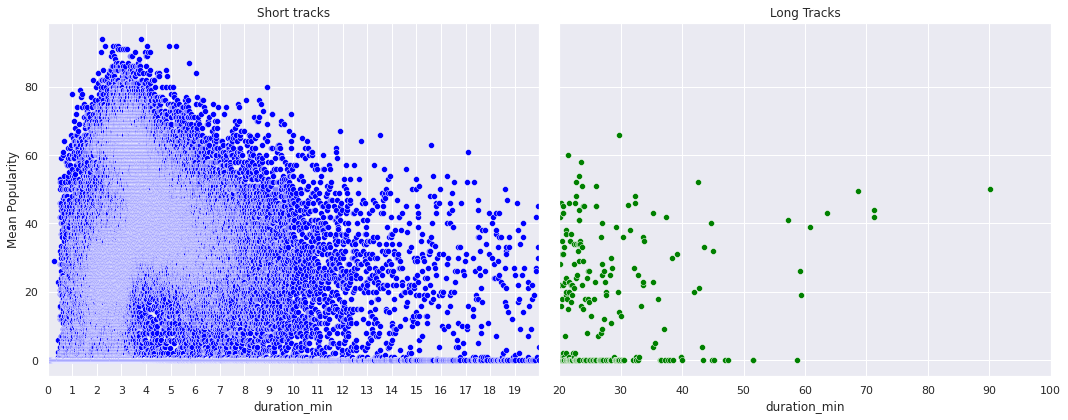

In [ ]:
#@title
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Short Tracks
ax1_data =  short_tracks.groupby('duration_min')['popularity'].mean().to_frame()
ax1 = sns.scatterplot(x='duration_min', y='popularity', data=ax1_data, color='blue', ax=ax1)
ax1.set_xticks(range(0,20,1))
ax1.set_xlim(0,20)
ax1.set_title('Short tracks')

# Long Tracks
ax2_data =  long_tracks.groupby('duration_min')['popularity'].mean().to_frame().reset_index()
ax2 = sns.scatterplot(x='duration_min', y='popularity', data=ax2_data, color='green', ax=ax2)
ax2.set_xticks(range(20,101,10))
ax2.set_xlim(20,100)
ax2.set_title('Long Tracks')
# ax2.axvline(x=45, color='r')
# ax2.axhline(y=26, xmin=0.31, color='black', linestyle='dashed')
font = {'family': 'serif',
        'color':  'red',
        'weight': 'normal',
        'size': 16,
        }
# ax2.text(x = 47, y = 80, s='cutoff=45', fontdict=font)
# ax2.text(x = 65, y = 20, s='median of means = 26', fontdict=font)

ax1.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

* There is a small sampled data for tracks longer than 45 min. 

* Transformer \ pre-processing: sklearn.preprocessing.MinMaxScaler()

###**Energy**

>mesure the intensity and activity, energetic track feels more fast loud and noisy

>It seem tat there is a reletively strong linear correlation of 0.497 correlation to the target

In [ ]:
#@title
a= df['energy'].corr(df['popularity']).round(3)
print(f'The pearson corr is -->{a:^10}')

The pearson corr is -->  0.497   


In [ ]:
#@title
df['energy'].describe()

count    169240.000000
mean          0.489632
std           0.267099
min           0.000000
25%           0.264000
50%           0.482000
75%           0.711000
max           1.000000
Name: energy, dtype: float64

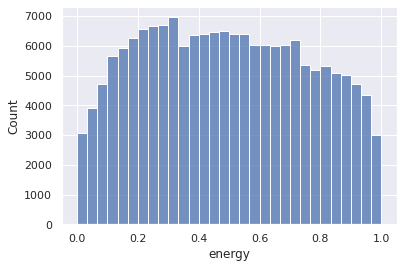

In [ ]:
#@title
sns.histplot(x='energy', data=df, bins=30)
plt.show()

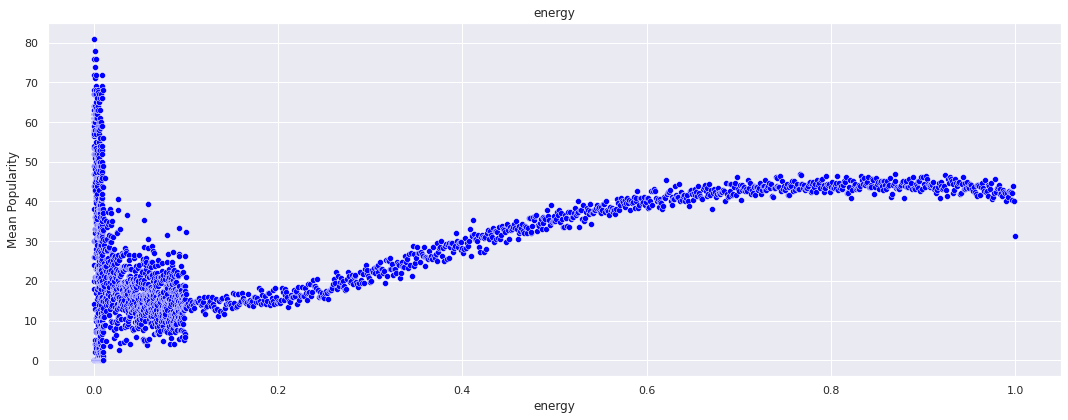

In [ ]:
#@title
fig, ax = plt.subplots(1, figsize=(15, 6), sharey=True, sharex = True)
ax_data =  df.groupby('energy')['popularity'].mean().to_frame()
ax = sns.scatterplot(x='energy', y='popularity', data=ax_data, color='blue', ax=ax)
ax.set_title('energy')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

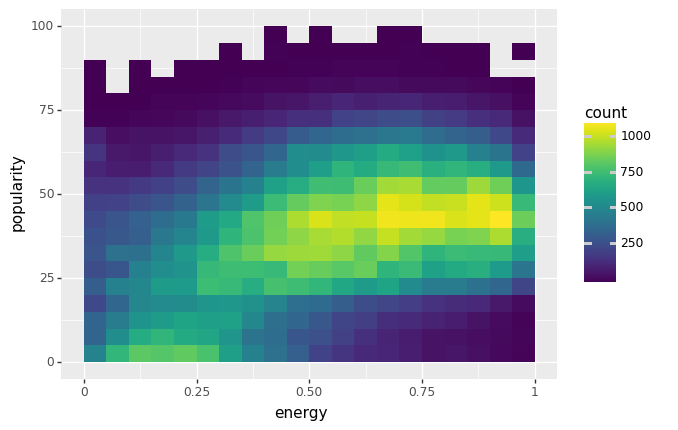

<ggplot: (-9223363288763296824)>

In [ ]:
df_test=df[['energy','popularity']]
ggplot(df_test, aes(x='energy', y='popularity')) + geom_bin2d(bins = 20)

### **Instrumentalness**
> The closer the Instrumentalness to 1 the greater liklyhood the track contain NO vocals

> Most of the data is distrebuted in both ends.

> we decided to devide the feature into three categorical groups and create a onehotencoder transformer to reshpae aour data

In [ ]:
#@title
a= df['instrumentalness'].corr(df['popularity']).round(3)
print(f'The pearson corr is -->{a:^10}')


The peardon corr is -->  -0.296  


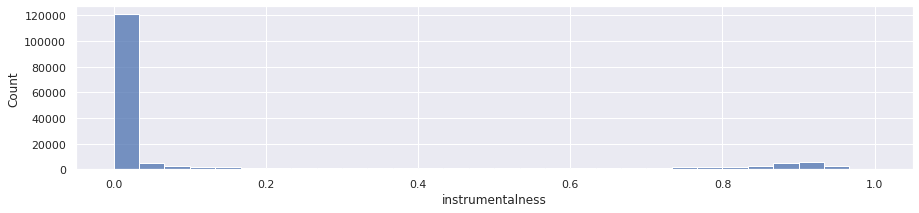

In [ ]:
#@title
fig, ax = plt.subplots(figsize = (15,3))
ax = sns.histplot(x='instrumentalness', data=df, bins=30)
plt.show()

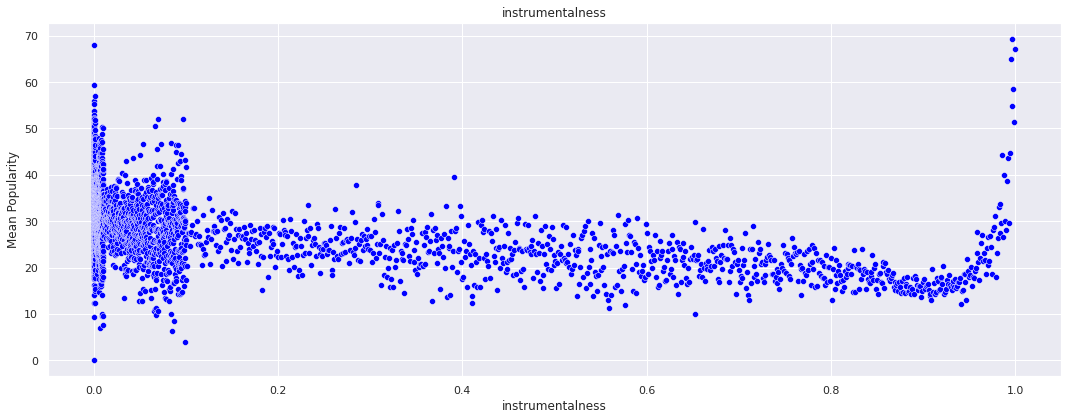

In [ ]:
#@title
fig, ax = plt.subplots(1, figsize=(15, 6), sharey=True, sharex = True)
ax_data =  df.groupby('instrumentalness')['popularity'].mean().to_frame()
ax = sns.scatterplot(x='instrumentalness', y='popularity', data=ax_data, color='blue', ax=ax)
ax.set_title('instrumentalness')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

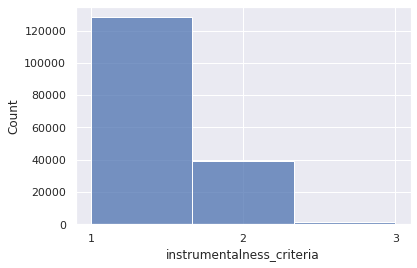

In [ ]:
#@title  { form-width: "20px" }
criteria= [df['instrumentalness'].between(0, 0.1),
           df['instrumentalness'].between(0.1000001, 0.95),
           df['instrumentalness'].between(0.950001, 1)]
values = [1, 2, 3]
df['instrumentalness_criteria'] = np.select(criteria, values, 0)
fig, ax = plt.subplots()
sns.histplot(x='instrumentalness_criteria',ax=ax, data=df, bins=3 )
ax.set_xticks(range(1,4))
plt.show()


### **liveness**

>Detect the presence of audience, high livness represent that the track was live

In [ ]:
#@title
a= df['liveness'].corr(df['popularity']).round(3)
print(f'The pearson corr is -->{a:^10}')

The pearson corr is -->  -0.076  


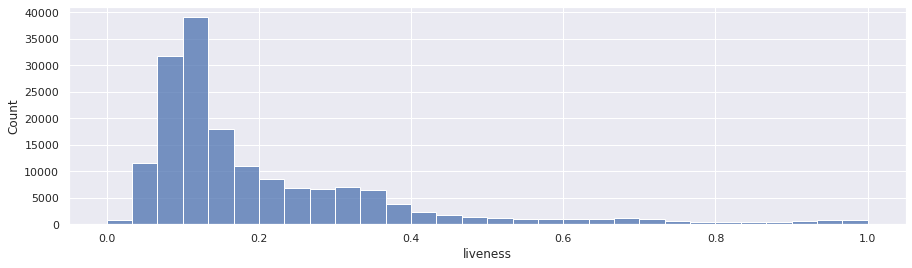

In [ ]:
#@title
fig, ax = plt.subplots(figsize=(15, 4))
sns.histplot(x='liveness', data=df, bins=30)
plt.show()

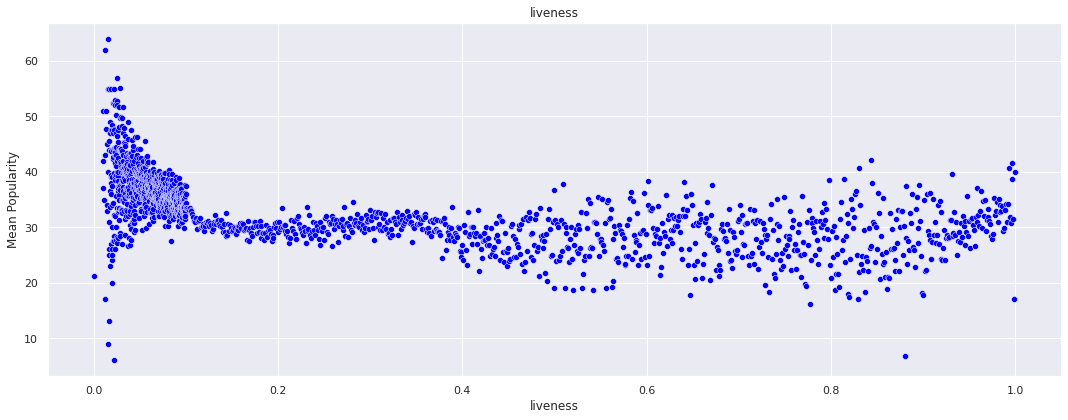

In [ ]:
#@title
fig, ax = plt.subplots(1, figsize=(15, 6), sharey=True, sharex = True)
ax_data =  df.groupby('liveness')['popularity'].mean().to_frame()
ax = sns.scatterplot(x='liveness', y='popularity', data=ax_data, color='blue', ax=ax)
ax.set_title('liveness')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

### **Loudness**

In [ ]:
df['loudness'].corr(df['popularity'])

0.4637365192270394

In [ ]:
df['loudness'].describe()

count    169240.000000
mean        -11.342179
std           5.642759
min         -60.000000
25%         -14.430000
50%         -10.453000
75%          -7.109000
max           3.855000
Name: loudness, dtype: float64

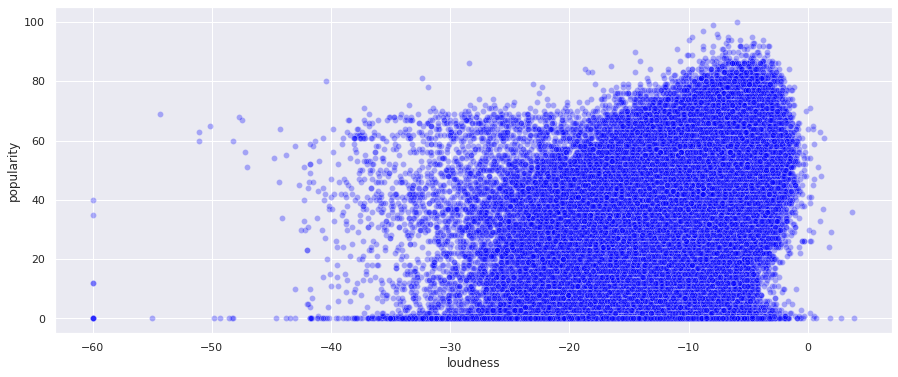

In [ ]:
fig, ax = plt.subplots(figsize = (15, 6))
sns.scatterplot(x='loudness', y='popularity', data=df, color='blue', alpha=0.3)
plt.show()

In [ ]:
for i in range(5,-60,-5):
  print(f"There are {df.loc[df['loudness'] < i, 'loudness'].count()} tracks below {i}")

There are 169240 tracks below 5
There are 169210 tracks below 0
There are 152404 tracks below -5
There are 90218 tracks below -10
There are 37878 tracks below -15
There are 13045 tracks below -20
There are 4008 tracks below -25
There are 1240 tracks below -30
There are 359 tracks below -35
There are 89 tracks below -40
There are 24 tracks below -45
There are 14 tracks below -50
There are 9 tracks below -55


### **Popularity (Target)**

In [ ]:
# Describe - all
df['popularity'].describe()

count    169240.000000
mean         31.668559
std          21.537377
min           0.000000
25%          12.000000
50%          34.000000
75%          48.000000
max         100.000000
Name: popularity, dtype: float64

In [ ]:
# Describe - Popularity > 0
df.loc[df['popularity']>0,'popularity'].describe()

count    142497.000000
mean         37.611929
std          18.093379
min           1.000000
25%          25.000000
50%          38.000000
75%          51.000000
max         100.000000
Name: popularity, dtype: float64

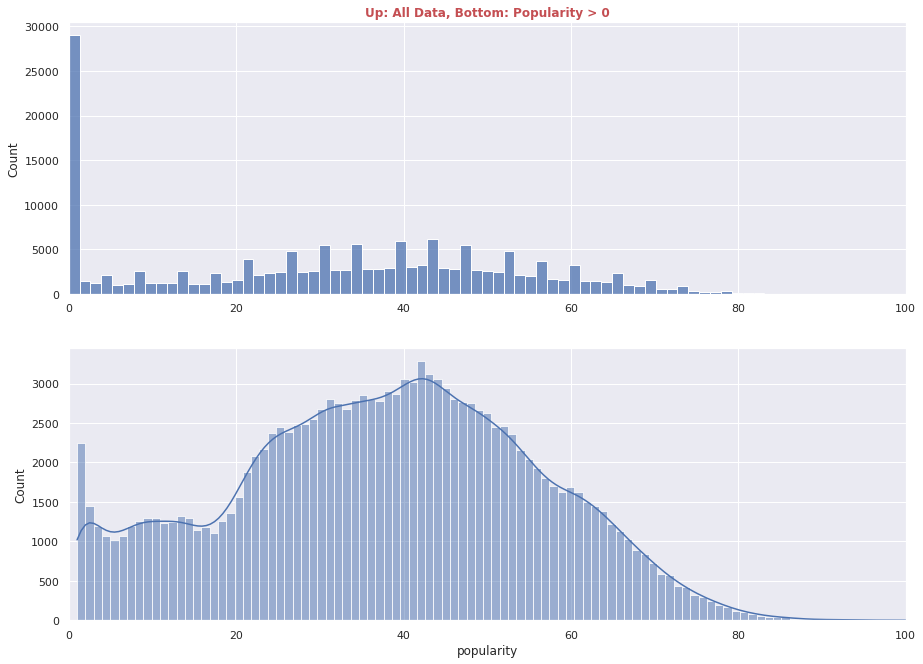

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 11))
ax1 = sns.histplot(data=df, x=df['popularity'], ax=ax1)
ax2 = sns.histplot(data=df, x=df.loc[df['popularity']>0,'popularity'], ax=ax2, kde=True)
ax1.set_xlim(0,100)
ax2.set_xlim(0,100)
ax1.set_xlabel('')
ax1.set_title('Up: All Data, Bottom: Popularity > 0', c='r', weight='bold')
plt.show()

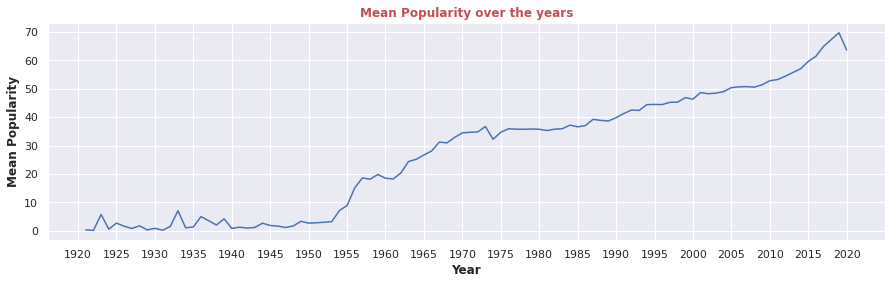

In [ ]:
fig, ax = plt.subplots(figsize=(15, 4))
ax = df.groupby('year')['popularity'].mean().plot()
ax.set_title('Mean Popularity over the years', c='r', weight='bold')
ax.set_ylabel('Mean Popularity', weight='bold')
ax.set_xlabel('Year', weight='bold')
ax.set_xticks(range(1920, 2021, 5))
plt.show()

### **Speechiness**
>Due to an obvious change in in speechiness trend vs. poopularity, we dicided to divide the records into two sub-groups.
The cutoff point is based on a deccision tree model.

In [ ]:
#@title  { form-width: "20px" }
a= df['speechiness'].corr(df['popularity']).round(2)
print(f'The pearson corr is -->{a:^10}')


The pearson corr is -->  -0.14   


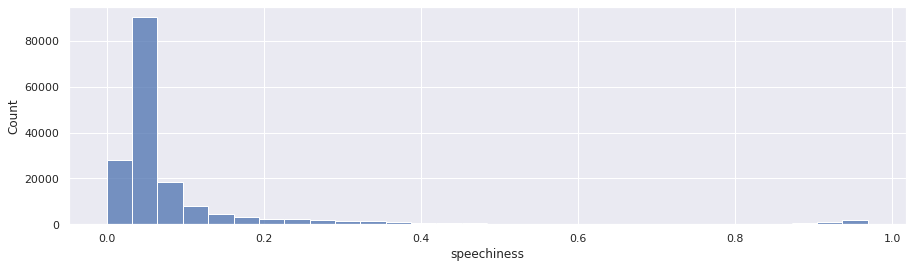

In [ ]:
#@title
fig, ax = plt.subplots(figsize=(15, 4))
sns.histplot(x='speechiness', data=df, bins=30)
plt.show()

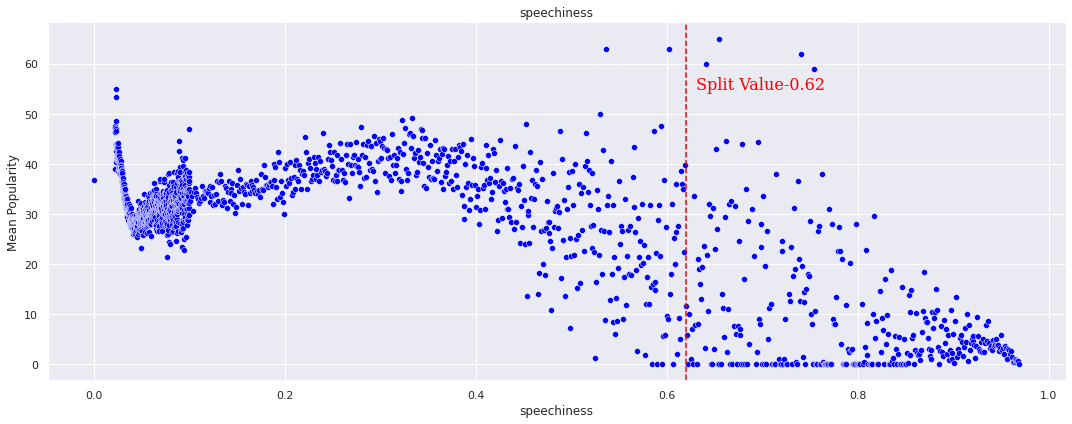

In [ ]:
#@title
fig, ax = plt.subplots(1, figsize=(15, 6), sharey=True, sharex = True)
ax_data =  df.groupby('speechiness')['popularity'].mean().to_frame()
ax = sns.scatterplot(x='speechiness', y='popularity', data=ax_data, color='blue', ax=ax)
ax.axvline(x=0.62,ymin=0,ymax=1,color='red',linestyle='dashed')
font = {'family': 'serif',
        'color':  'red',
        'weight': 'normal',
        'size': 16,
        }
ax.text(x = 0.63, y = 55, s='Split Value-0.62',fontdict=font)
ax.set_title('speechiness')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

#### **Decision Tree**

In [2]:
#@title  { form-width: "20px" }
X_sp = df['speechiness'].to_frame()
y_sp = df['popularity']
X_train, X_test, y_train, y_test = split(X_sp, y_sp , test_size = 0.2 , random_state = 42 )
model = DecisionTreeRegressor(max_leaf_nodes=2)
model.fit(X_train, y_train)

dot_data = StringIO()
export_graphviz(model, out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

NameError: ignored

In [ ]:
y_pred = model.predict(X_train)
rmse = np.sqrt(mse(y_train, y_pred))
print(f"RMSE_Train = {rmse:.2f}")

RMSE_Train = 21.15


In [ ]:
# model.fit(X_test, y_test)
y_test_pred = model.predict(X_test)
rmse = np.sqrt(mse(y_test, y_test_pred))
print(f"RMSE_test = {rmse:.2f}")

RMSE_test = 21.00


### **Tempo**

* The linear correlation between tempo and popularity is 0.1335.

* Outliers - there is a 145 values of 0. need to be replaced. 

In [ ]:
a = df['tempo'].corr(df['popularity']).round(2)
print(f"Linear correlation is {a}")

Linear correlation is 0.13


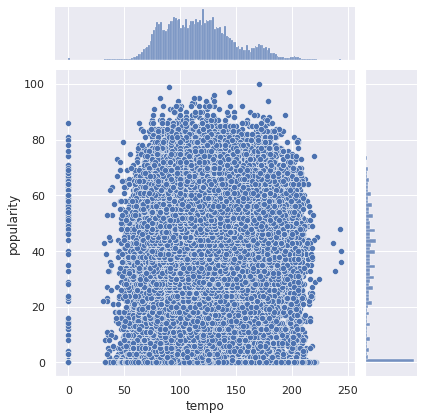

In [ ]:
sns.jointplot(x='tempo', y='popularity', data=df)
plt.show()

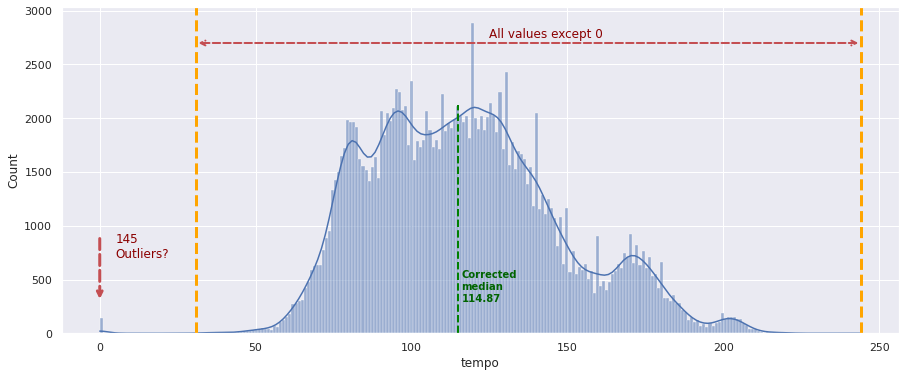

In [ ]:
#@title  { form-width: "20px" }
fig, ax = plt.subplots(figsize = (15, 6))
ax = sns.histplot(x='tempo', data=df, bins=250, kde=True)
ax.text(s='145\nOutliers?', x= 5, y=700, fontdict={'size': 12, 'c': 'darkred'})
ax.text(s='All values except 0', x= 125, y=2750, fontdict={'size': 12, 'c': 'darkred'})
ax.text(s='Corrected\nmedian\n114.87', x= 116, y=300, fontdict={'size': 10, 'c': 'darkgreen', 'weight': 'bold'})
ax.axvline(x=114.87, ymin=0, ymax=0.7, color='green', linestyle='dashed', linewidth=2)
ax.axvline(x=30.95, ymin=0, ymax=1, color='orange', linestyle='dashed', linewidth=3)
ax.axvline(x=244.09, ymin=0, ymax=1, color='orange', linestyle='dashed', linewidth=3)
ax.annotate("", xy=(31, 2700), xytext=(244, 2700), arrowprops=dict(arrowstyle="<->", color='r', linestyle='dashed', linewidth=2))
ax.annotate("", xy=(0, 300), xytext=(0, 900), arrowprops=dict(arrowstyle="->", color='r', linestyle='dashed', linewidth=3))
plt.show()

This feature will need an imputer and scaler.

### **Valence**

In [ ]:
a = df['valence'].corr(df['popularity']).round(2)
print(f"Linear correlation is {a}")

Linear correlation is 0.01


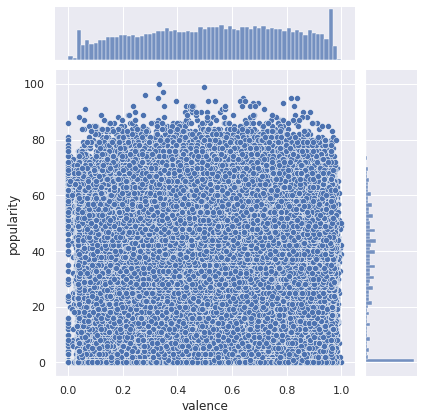

In [ ]:
sns.jointplot(x='valence', y='popularity', data=df)
plt.show()

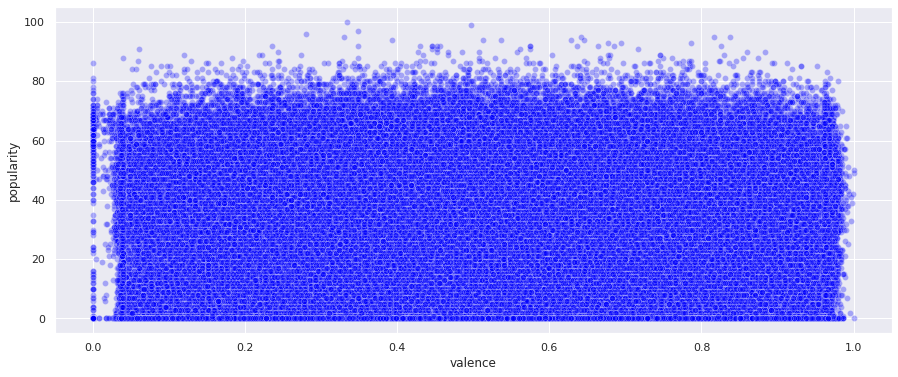

In [ ]:
fig, ax = plt.subplots(figsize = (15, 6))
sns.scatterplot(x='valence', y='popularity', data=df, color='blue', alpha=0.3)
plt.show()

### **Year**

* The year attribute is linearly close to the popularity target (corr = 0.88)

* Each year contains different quantities of tracks. Most of the years are 2000 or 4000, due to the 2000 maximal batch limit in the Spoyify's API.

* There are some values with 0 popularity in 2020. These is a relatively new songs in the dataset, from 6/2020, prior to data extraction.

In [ ]:
a = df['year'].corr(df['popularity']).round(2)
print(f"Linear correlation is {a}")

Linear correlation is 0.88


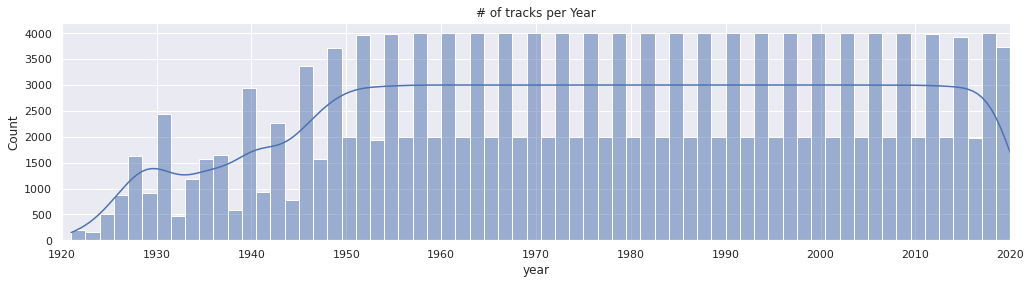

In [ ]:
#@title
fig, ax = plt.subplots(figsize=(17, 4))
ax = sns.histplot(data=df, x='year', kde=True)
ax.set_xlim(1920,2020)
ax.set_xticks(range(1920, 2021, 10))
ax.set_title('# of tracks per Year')
plt.show()

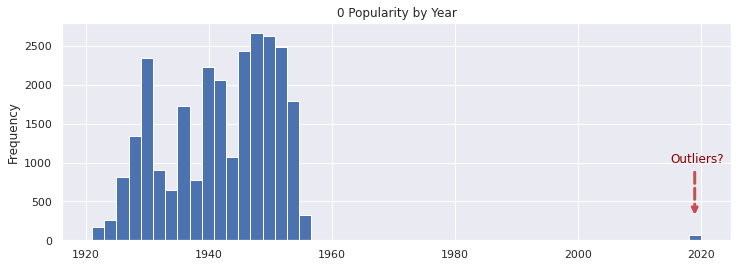

In [ ]:
#@title
fig, ax = plt.subplots(figsize=(12, 4))
ax = df['year'].loc[df['popularity']==0].plot.hist(bins=50)
ax.set_title('0 Popularity by Year')
ax.text(s='Outliers?', x= 2015, y=1000, fontdict={'size': 12, 'c': 'darkred'})
ax.annotate("", xy=(2019, 300), xytext=(2019, 900), arrowprops=dict(arrowstyle="->", color='r', linestyle='dashed', linewidth=3))
plt.show()

Due to the very high linear correlation between the year and the popularity, this feature will be excluded from our models.

# **Pre-Processing**

First, we import a clean version of the data, without id, name, year and release_date and remove the duplicates.

In [ ]:
# Read column names from file
cols = list(pd.read_csv('data.csv', nrows =1))
df = pd.read_csv('data.csv', usecols=[i for i in cols if i not in ['id','name','release_date','year']])

# Remove duplicated
df = df[~df.duplicated()==1]
# df = df.sample(frac=0.3)
#Split the data to train and test
X_train, X_test, y_train, y_test = split(df.drop('popularity', axis=1), df['popularity'], test_size = 0.2, random_state = 12345)

After exploring the data, some features need pre-processing. This will be done in the following order:

1. Unique feature transformers

2. OneHotEncoder (aka dummies) for relevant features

3. MinMaxScaling for relevant features

4. Target scaling

### **AritistsTransformer**

Here we need to replace object data of the artists with some numerical indicator that identify the artist.

In [ ]:
class ArtistsTransformer():
  """ This transformer recives a DF with a feature 'artists' of dtype object
      and convert the feature to a float value as follows:
      1. Replace the data with the artists mean popularity
      2. Replace values where artists appear less than MinCnt with y.mean()
      3. Replace values where artists appear more than MaxCnt with 0
      
      PARAMETERS:
      ----------
      MinCnt (int): Minimal treshold of artisits apear in dataset, default = 3
      MaxCnt (int): Maximal treshold of artisits apear in dataset, default = 600

      RERTURN:
      ----------
      A DataFrame with converted artists str feature to ordinal floats
  """

  def __init__(self, MinCnt = 3.0, MaxCnt = 600.0):
      self.MinCnt = MinCnt
      self.MaxCnt = MaxCnt
      self.artists_df = None
  
  def fit (self, X, y):
      self.artists_df =  y.groupby(X.artists).agg(['mean', 'count'])
      self.artists_df.loc['unknown'] = [y.mean(), 1]
      self.artists_df.loc[self.artists_df['count'] <= self.MinCnt, 'mean'] = y.mean()
      self.artists_df.loc[self.artists_df['count'] >= self.MaxCnt, 'mean'] = 0
      return self

  def transform(self, X, y=None):
      X['artists'] = np.where(X['artists'].isin(self.artists_df.index), X['artists'], 'unknown')
      X['artists'] = X['artists'].map(self.artists_df['mean'])
      return X

In [ ]:
# Apply AritistsTransformer on train and test seperatly
artists_transformer = ArtistsTransformer(MinCnt=2)
X_train = artists_transformer.fit(X_train, y_train).transform(X_train, y_train)
X_test = artists_transformer.transform(X_test, y_test)

### **Instrumentalness Transformer**

In [ ]:
def instrumentalness_criteria(X):
    X['instrumentalness'] = list(map((lambda x: 1 if x < 0.1 else (3 if x > 0.95 else 2)), X.instrumentalness))

instrumentalness_tranformer = FunctionTransformer(instrumentalness_criteria)
instrumentalness_tranformer.transform(X_train)
instrumentalness_tranformer.transform(X_test)

### **Speechiness Transformer**

In [ ]:
def speech_criteria(X):
    X['speechiness'] = list(map((lambda x: 1 if x > 0.62 else 0), X.speechiness))

speech_tranformer = FunctionTransformer(speech_criteria)
speech_tranformer.transform(X_train)
speech_tranformer.transform(X_test)

### **Tempo Transformer**

In [ ]:
class ReplaceZeroTransformer():
    """Eliminates Zero values from tempo columns and replace it 
       with the median or mean of non-zero values as specified.
       defaut is set to 'median'.
    """

    def __init__(self, method='median'):
        self.method = method

    def transform(self, X):
        if self.method == 'median':
            X.loc[X['tempo']==0, 'tempo'] = X.loc[X['tempo']>0, 'tempo'].median()
        elif self.method == 'mean':
            X.loc[X['tempo']==0, 'tempo'] = X.loc[X['tempo']>0, 'tempo'].mean()
        else:
            raise Exception("Method can be 'median' or 'mean' only!")
        return X

In [ ]:
tempo_transformer = ReplaceZeroTransformer()
X_train = tempo_transformer.transform(X_train)
X_test = tempo_transformer.transform(X_test)

### **OneHotEncoder**

We use OneHotEncoder from SKlearn to create dummies

In [ ]:
ohe = OneHotEncoder(categories='auto', drop='first')

# Train
feature_arr = ohe.fit_transform(X_train[['instrumentalness','key']]).toarray()
columns_key = ['key_'+str(i) for i in list(set(X_train['key'].values))[1:]]
instrumentalness_key = ['ins_'+str(i) for i in list(set(X_train['instrumentalness'].values))[1:]]
feature_labels = columns_key + instrumentalness_key
feature_labels = np.concatenate((feature_labels), axis=None)
features = pd.DataFrame(feature_arr, columns = feature_labels, index = X_train.index)
X_train = pd.concat([X_train, features], axis=1).drop(['key','instrumentalness'], axis=1)

# Test
feature_arr = ohe.fit_transform(X_test[['instrumentalness','key']]).toarray()
columns_key = ['key_'+str(i) for i in list(set(X_test['key'].values))[1:]]
instrumentalness_key = ['ins_'+str(i) for i in list(set(X_test['instrumentalness'].values))[1:]]
feature_labels = columns_key + instrumentalness_key
feature_labels = np.concatenate((feature_labels), axis=None)
features = pd.DataFrame(feature_arr, columns = feature_labels, index = X_test.index)
X_test = pd.concat([X_test, features], axis=1).drop(['key','instrumentalness'], axis=1)

### **MinMaxScaler Encoder**

In [ ]:
scaler = MinMaxScaler()
cols = ['artists','duration_ms','loudness','tempo']
X_train[cols] = scaler.fit_transform(X_train[cols])
X_test[cols] = scaler.fit_transform(X_test[cols])

### **Target scaling**

In [ ]:
# Divide the popularity by 100
y_train = y_train / 100
y_test = y_test / 100

### **Verification**

In [ ]:
nl = '\n'
print(f'X_train shape is: {X_train.shape} {nl}y_train shape is: {y_train.shape} {nl}X_test shape is: {X_test.shape} {nl}y_test shape is: {y_test.shape}')

X_train shape is: (135184, 25) 
y_train shape is: (135184,) 
X_test shape is: (33796, 25) 
y_test shape is: (33796,)


In [ ]:
X_train.head(3)

acousticness   artists  danceability  ...  key_11  ins_2  ins_3
31980        0.4110  0.383463         0.740  ...     0.0    0.0    0.0
92099        0.7540  0.308461         0.409  ...     0.0    0.0    0.0
10927        0.0205  0.362319         0.499  ...     0.0    0.0    0.0

[3 rows x 25 columns]

In [ ]:
X_train.describe().drop(['count','25%', '50%', '75%'])

acousticness   artists  danceability  ...    key_11     ins_2     ins_3
mean      0.490510  0.376143      0.538910  ...  0.103934  0.070600  0.062509
std       0.375787  0.195347      0.175158  ...  0.305176  0.256156  0.242078
min       0.000000  0.000000      0.000000  ...  0.000000  0.000000  0.000000
max       0.996000  1.000000      0.986000  ...  1.000000  1.000000  1.000000

[4 rows x 25 columns]

In [ ]:
y_train.describe().drop(['count','25%', '50%', '75%'])

mean    0.317507
std     0.215235
min     0.000000
max     1.000000
Name: popularity, dtype: float64

# **Models**

## **Linear Model**

### **Option 1: selected features only (corr > 0.2)**

In [ ]:
LR = LinearRegression()
cols = [col for col in X_train.columns if abs(X_train[col].corr(y_train))>0.2]

# Fit the model and
LR.fit(X_train.drop(columns=cols), y_train)

# Train Predicting with the model
y_train_pred = LR.predict(X_train.drop(columns=cols)).clip(0, 1)

# RMSE Train
LR_rmse = np.sqrt(mse(y_train, y_train_pred))
print(f"RMSE Train = {LR_rmse:.5f}")

#Predicting with the model
y_test_pred = LR.predict(X_test.drop(columns=cols)).clip(0, 1)

# RMSE Test
LR_rmse = np.sqrt(mse(y_test, y_test_pred))
print(f"RMSE Test = {LR_rmse:.5f}")

RMSE Train = 0.20680
RMSE Test = 0.20676


### **Option 2: All features**

In [ ]:
LR = LinearRegression()

# Fit the model and
LR.fit(X_train, y_train)

# Train Predicting with the model
y_train_pred = LR.predict(X_train).clip(0, 1)

# RMSE Train
LR_rmse = np.sqrt(mse(y_train, y_train_pred))
print(f"RMSE Train = {LR_rmse:.6f}")

#Predicting with the model
y_test_pred = LR.predict(X_test).clip(0, 1)

# RMSE Test
LR_rmse = np.sqrt(mse(y_test, y_test_pred))
print(f"RMSE Test = {LR_rmse:.6f}")

RMSE Train = 0.122614
RMSE Test = 0.129278


In [ ]:
from IPython.display import display, Math

def get_printable_equt(df, inter, coef):
  equtation = '$y = ' + f'{inter:.2f} '
  
  for i, co in enumerate(coef):
    if i == len(coef) - 1:
        equtation = equtation + f'+ {co:.2f} {(df.columns)[i]}$'
    else:
        equtation = equtation + f'+ {co:.2f} {(df.columns)[i]}'

  return display(Math(equtation))

get_printable_equt(X_train, LR.intercept_, LR.coef_)

<IPython.core.display.Math object>

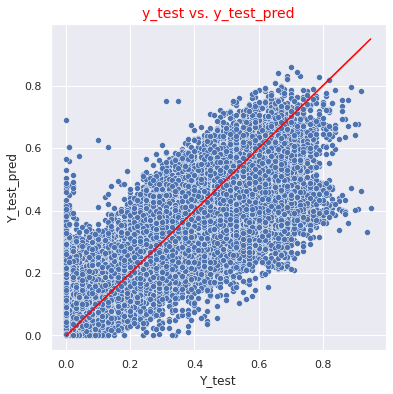

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_test, y=y_test_pred)
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax)
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')
ax.set_title('y_test vs. y_test_pred', fontsize=14, color='red')
plt.show()

In [ ]:
import statsmodels.api as sm
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             popularity   R-squared (uncentered):                   0.895
Model:                            OLS   Adj. R-squared (uncentered):              0.895
Method:                 Least Squares   F-statistic:                          3.847e+04
Date:                Thu, 15 Oct 2020   Prob (F-statistic):                        0.00
Time:                        07:58:03   Log-Likelihood:                          75239.
No. Observations:              113216   AIC:                                 -1.504e+05
Df Residuals:                  113191   BIC:                                 -1.502e+05
Df Model:                          25                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
acousticness    -0.0996      0.002    -60.610      0.000      -0.103      -0.096
artists          0.6236      0.002    263.162      0.000       0.619       0.628
danceability     0.1417      0.003     49.197      0.000       0.136       0.147
duration_ms      0.0633      0.016      3.839      0.000       0.031       0.096
energy           0.0210      0.003      7.311      0.000       0.015       0.027
explicit         0.0479      0.001     32.408      0.000       0.045       0.051
liveness        -0.0513      0.002    -23.676      0.000      -0.056      -0.047
loudness         0.1246      0.004     29.688      0.000       0.116       0.133
mode            -0.0032      0.001     -3.816      0.000      -0.005      -0.002
speechiness     -0.1058      0.003    -40.035      0.000      -0.111      -0.101
tempo            0.0317      0.003     11.897      0.000       0.027       0.037
valence         -0.0999      0.002    -50.679      0.000      -0.104      -0.096
key_1           -0.0198      0.001    -20.962      0.000      -0.022      -0.018
key_2            0.0423      0.004     10.869      0.000       0.035       0.050
key_3            0.0076      0.002      4.487      0.000       0.004       0.011
key_4           -0.0011      0.002     -0.746      0.456      -0.004       0.002
key_5           -0.0062      0.002     -2.954      0.003      -0.010      -0.002
key_6            0.0036      0.002      2.106      0.035       0.000       0.007
key_7            0.0019      0.002      1.216      0.224      -0.001       0.005
key_8            0.0077      0.002      3.932      0.000       0.004       0.012
key_9            0.0014      0.001      0.984      0.325      -0.001       0.004
key_10           0.0042      0.002      2.358      0.018       0.001       0.008
key_11          -0.0007      0.002     -0.444      0.657      -0.004       0.002
ins_2           -0.0004      0.002     -0.216      0.829      -0.004       0.003
ins_3            0.0003      0.002      0.165      0.869      -0.003       0.004
==============================================================================
Omnibus:                     4560.460   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6698.732
Skew:                           0.390   Prob(JB):                         0.00
Kurtosis:                       3.901   Cond. No.                         73.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## **KNN Model**

Due to long running time, we sampled the original data with frac = 0.3.

### **5 to 100 neighbors**

In [ ]:
RMSE1_train, RMSE1_test = [], []
  
for i in range(5,101,5):
  knn = KNeighborsRegressor(n_neighbors=i)
  knn.fit(X_train,y_train)
  y_train_pred = knn.predict(X_train)
  knn_train_rmse = np.sqrt(mse(y_train, y_train_pred))
  RMSE1_train.append(knn_train_rmse.round(3))
  y_test_pred = knn.predict(X_test)
  knn_test_rmse = np.sqrt(mse(y_test, y_test_pred))
  RMSE1_test.append(knn_test_rmse.round(3))

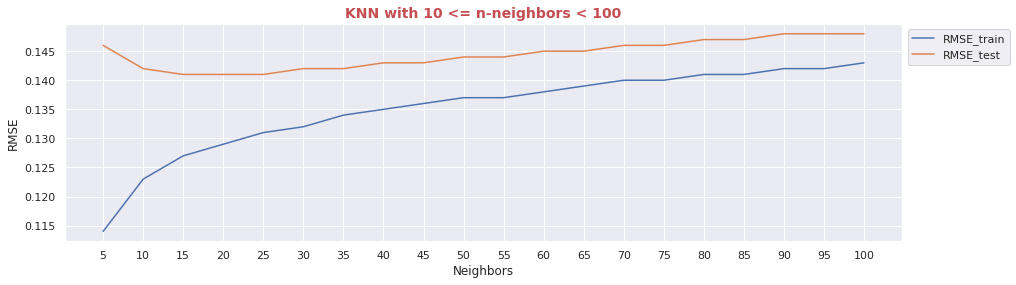

In [ ]:
fig, ax = plt.subplots(figsize=(15,4))
x = np.arange(5, 101, 5)
ax = sns.lineplot(x=x, y=RMSE1_train)
sns.lineplot(x=x, y=RMSE1_test, ax=ax)
ax.legend(labels=['RMSE_train', 'RMSE_test'], bbox_to_anchor=(1, 1))
ax.set_xlabel('Neighbors')
ax.set_ylabel('RMSE')
ax.set_xticks(np.arange(5,101,5))
ax.set_title('KNN with 10 <= n-neighbors < 100', c='r', fontdict={'c':'r', 'fontsize':14, 'weight':'bold'})
plt.show()

In [ ]:
gap1 = [RMSE1_test[num]-RMSE1_train[num] for num, i in enumerate(RMSE1_train)]
min(gap1).round(3)

0.005

In [ ]:
print(gap1.index(min(gap1)))
print(f'RMSE Train: {RMSE1_train[19]}, RMSE_test: {RMSE1_test[19]}')

19
RMSE Train: 0.143, RMSE_test: 0.148


### **100 to 200 neighbors**

In [ ]:
RMSE_train, RMSE_test = [], []
  
for i in range(100,201,5):
  knn = KNeighborsRegressor(n_neighbors=i)
  knn.fit(X_train,y_train)
  y_train_pred = knn.predict(X_train)
  knn_train_rmse = np.sqrt(mse(y_train, y_train_pred))
  RMSE_train.append(knn_train_rmse.round(3))
  y_test_pred = knn.predict(X_test)
  knn_test_rmse = np.sqrt(mse(y_test, y_test_pred))
  RMSE_test.append(knn_test_rmse.round(3))

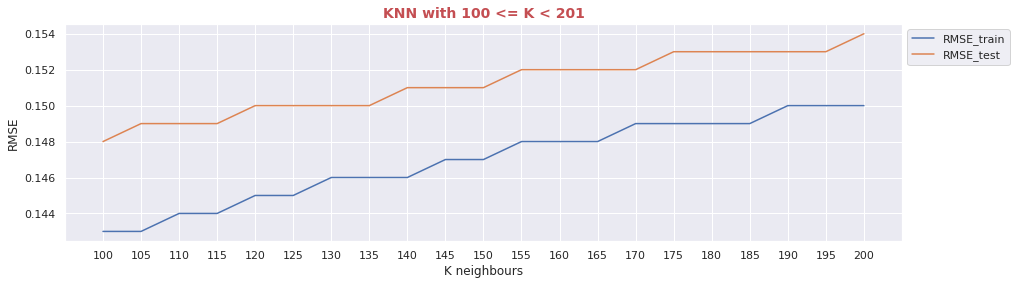

In [ ]:
fig, ax = plt.subplots(figsize=(15,4))
x = np.arange(100, 201, 5)
ax = sns.lineplot(x=x, y=RMSE_train)
sns.lineplot(x=x, y=RMSE_test, ax=ax)
# ax.axvline(x=180, ymin=0, ymax=0.3, color='blue')
# ax.axvline(x=139, ymin=0.5, ymax=0.8, color='orange')
ax.legend(labels=['RMSE_train', 'RMSE_test'], bbox_to_anchor=(1, 1))
ax.set_xticks(np.arange(100,201,5))
ax.set_xlabel('K neighbours')
ax.set_ylabel('RMSE')
ax.set_title('KNN with 100 <= K < 201', c='r', fontdict={'c':'r', 'fontsize':14, 'weight':'bold'})
plt.show()

In [ ]:
gap2 = [RMSE_test[num]-RMSE_train[num] for num, i in enumerate(RMSE_train)]
min(gap2)

0.0030000000000000027

In [ ]:
print(gap2.index(min(gap2)))
print(RMSE_train[14])#, RMSE_train.index(min(RMSE_train)))
print(RMSE_test[14])#, RMSE_test.index(min(RMSE_test)))
print(f'RMSE Train: {RMSE_train[14]}, RMSE_test: {RMSE_test[14]}')

14
0.149
0.152
RMSE Train: 0.149, RMSE_test: 0.152


## **Decision Tree Model**

### **Option 1: single run**

In [ ]:
# single run
tree = DecisionTreeRegressor(max_leaf_nodes=41, min_samples_split=2000)
tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train).clip(0, 1)
train_rmse = np.sqrt(mse(y_train, y_train_pred))
y_test_pred = tree.predict(X_test).clip(0, 1)
test_rmse = np.sqrt(mse(y_test, y_test_pred))
print(f'train: {train_rmse}')
print(f'test: {test_rmse}')

train: 0.10708562102328552
test: 0.11438255935164143


### **Option 2: loop**

In [ ]:
RMSE3_train, RMSE3_test = [], []

for i in range(2,200):
  tree = DecisionTreeRegressor(random_state = 15, max_leaf_nodes=i)
  tree.fit(X_train, y_train)
  y_train_pred = tree.predict(X_train).clip(0, 1)
  train_rmse = np.sqrt(mse(y_train, y_train_pred))
  RMSE3_train.append(train_rmse.round(3))
  y_test_pred = tree.predict(X_test).clip(0, 1)
  test_rmse = np.sqrt(mse(y_test, y_test_pred))
  RMSE3_test.append(test_rmse.round(3))

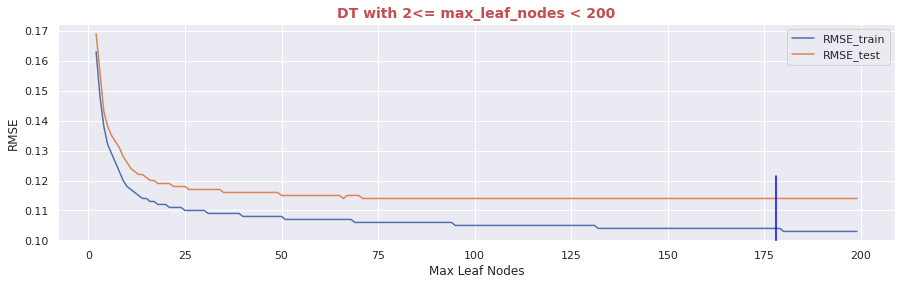

In [ ]:
fig, ax = plt.subplots(figsize=(15,4))
x = np.arange(2, 200)
ax = sns.lineplot(x=x, y=RMSE3_train)
sns.lineplot(x=x, y=RMSE3_test, ax=ax)
ax.axvline(x=178, ymin=0, ymax=0.3, color='blue')
# ax.axvline(x=139, ymin=0.5, ymax=0.8, color='orange')
ax.legend(labels=['RMSE_train', 'RMSE_test'], bbox_to_anchor=(1, 1))
ax.set_xlabel('Max Leaf Nodes')
ax.set_ylabel('RMSE')
ax.set_title('DT with 2<= max_leaf_nodes < 200', c='r', fontdict={'c':'r', 'fontsize':14, 'weight':'bold'})
plt.show()

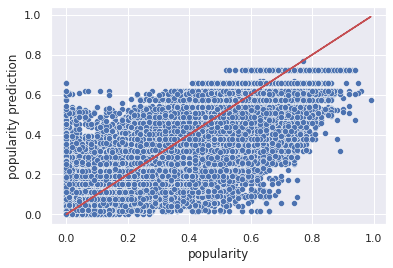

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')
ax.set_ylabel('popularity prediction')
plt.show()

In [ ]:
gap3 = [(RMSE3_train[i]/RMSE3_test[i]) for i, num in enumerate(RMSE3_train)]

print(f'Minimum validiation is: {min(gap3):.3%} in index number {gap3.index(min(gap3))}')
print(f'Maximum validiation is: {max(gap3):.3%} in index number {gap3.index(max(gap3))}')


Minimum validiation is: 90.351% in index number 178
Maximum validiation is: 96.503% in index number 2


In [ ]:
print(RMSE3_train[178])
print(RMSE3_test[178])

0.103
0.114


In [ ]:
# single run
tree = DecisionTreeRegressor(max_leaf_nodes=180)
tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train).clip(0, 1)
train_rmse = np.sqrt(mse(y_train, y_train_pred))
y_test_pred = tree.predict(X_test).clip(0, 1)
test_rmse = np.sqrt(mse(y_test, y_test_pred))
print(f'train: {train_rmse}')
print(f'test: {test_rmse}')

train: 0.10348442108825844
test: 0.14193653294823586


In [ ]:
print('Feature importances:')
for i, col in enumerate(X_train.columns):
  print(f'{col:12}: {tree.feature_importances_[i]:.3f}')

Feature importances:
acousticness: 0.096
artists     : 0.841
danceability: 0.004
duration_ms : 0.007
energy      : 0.004
explicit    : 0.007
liveness    : 0.004
loudness    : 0.026
mode        : 0.000
speechiness : 0.000
tempo       : 0.001
valence     : 0.008
key_1       : 0.001
key_2       : 0.001
key_3       : 0.000
key_4       : 0.000
key_5       : 0.000
key_6       : 0.000
key_7       : 0.000
key_8       : 0.000
key_9       : 0.000
key_10      : 0.000
key_11      : 0.000
ins_2       : 0.000
ins_3       : 0.000


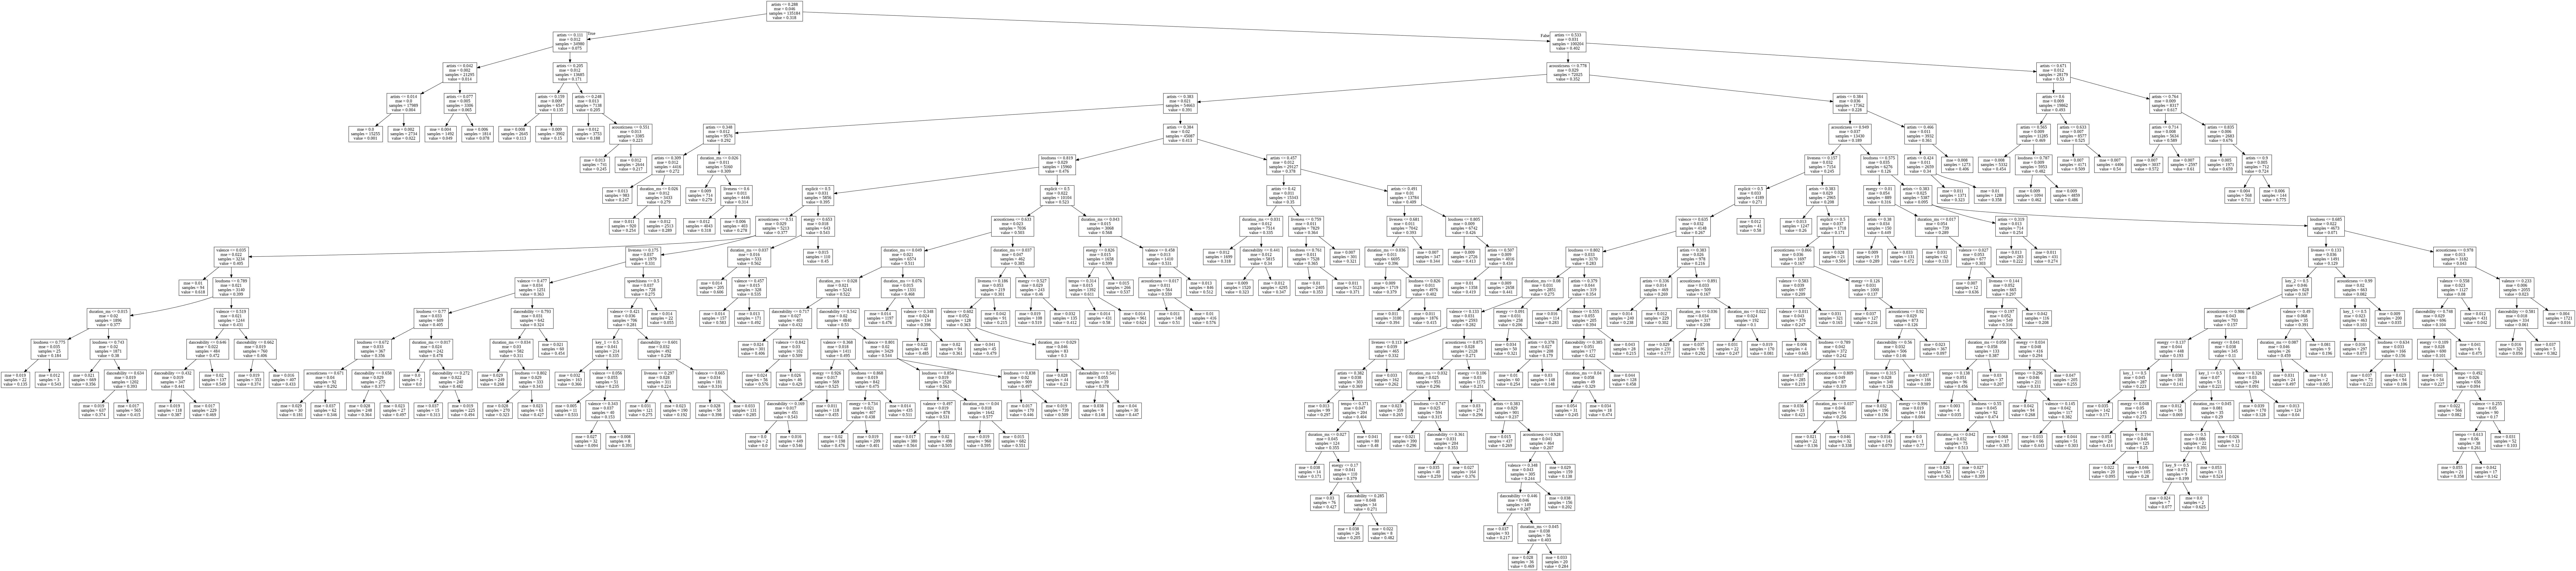

In [ ]:
import pydotplus

dot_data = StringIO()
export_graphviz(tree, out_file=dot_data,feature_names=X_train.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [ ]:
export_graphviz(tree, out_file="tree.dot", feature_names = X_train.columns)